# Final Experiment (Binary Classification)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, precision_recall_curve, PrecisionRecallDisplay
from tensorflow.keras.models import load_model
from pathlib import Path

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, load_fusioned_dataset
from src.lib.time_series_augmentation.utils.augmentation import jitter, rotation
from src.models.CNNLSTM import CNNLSTM
from src.models.CNNLSTMfusioned import CNNLSTM_fusioned
from src.models.RCNN import RCNN
from src.models.RCNNfusioned import RCNN_fusioned
from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
epochs = 100

cnnlstm_auc = []
rcnn_auc = []

In [3]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

## 1. Unimodal Body (Skeleton Pose Estimation)

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(783, 1, 350, 35) (783, 1)
(274, 1, 350, 35) (274, 1)


In [5]:
jitter_X = jitter(X, sigma=0.03)
reshaped_X = X.reshape((X.shape[0], X.shape[2], X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X[0:200], jitter_X[0:200]), axis=0)
add_y = np.concatenate((y[0:200], y[0:200]), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

(1183, 1, 350, 35)

### 1.1 CNN + BiLSTM

In [6]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_body_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_body_model.save(model_path / 'body_binary_cnnlstm.h5')

Epoch 1/100
22/22 - 73s - loss: 0.6686 - accuracy: 0.6009 - auc: 0.6305 - precision: 0.5799 - recall: 0.6294 - f1_score: 0.6513 - val_loss: 0.7929 - val_accuracy: 0.5063 - val_auc: 0.5276 - val_precision: 0.5063 - val_recall: 1.0000 - val_f1_score: 0.6723 - 73s/epoch - 3s/step
Epoch 2/100
22/22 - 67s - loss: 0.6451 - accuracy: 0.6151 - auc: 0.6746 - precision: 0.5989 - recall: 0.6147 - f1_score: 0.6513 - val_loss: 1.0048 - val_accuracy: 0.5063 - val_auc: 0.5631 - val_precision: 0.5063 - val_recall: 1.0000 - val_f1_score: 0.6723 - 67s/epoch - 3s/step
Epoch 3/100
22/22 - 65s - loss: 0.6341 - accuracy: 0.6548 - auc: 0.6938 - precision: 0.6359 - recall: 0.6676 - f1_score: 0.6513 - val_loss: 1.0711 - val_accuracy: 0.5063 - val_auc: 0.5712 - val_precision: 0.5063 - val_recall: 1.0000 - val_f1_score: 0.6723 - 65s/epoch - 3s/step
Epoch 4/100
22/22 - 66s - loss: 0.6184 - accuracy: 0.6577 - auc: 0.7158 - precision: 0.6427 - recall: 0.6559 - f1_score: 0.6513 - val_loss: 1.0986 - val_accuracy: 0.5

KeyboardInterrupt: 

#### Training performance and variance

In [ ]:
body_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_cnnlstm_train_results

{'Accuracy': 0.9418312728404998,
 'ROC/AUC': 0.9845370829105378,
 'Precision': 0.9438284933567047,
 'Recall': 0.9361608922481537,
 'F1-score': 0.6534521996974945}

In [ ]:
body_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
body_cnnlstm_train_var

{'Accuracy': 0.0004363359917683241,
 'ROC/AUC': 5.712937769363436e-05,
 'Precision': 0.00041560802428879383,
 'Recall': 0.0006020720407372337,
 'F1-score': 3.830395711052148e-05}

#### Validation performance and variance

In [ ]:
body_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_cnnlstm_val_results

{'Accuracy': 0.6360921859741211,
 'ROC/AUC': 0.6895731866359711,
 'Precision': 0.6196757972240448,
 'Recall': 0.6802591025829315,
 'F1-score': 0.6509565472602844}

In [ ]:
body_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
body_cnnlstm_val_var

{'Accuracy': 0.00280915291138939,
 'ROC/AUC': 0.003099318418134835,
 'Precision': 0.0037902097012520028,
 'Recall': 0.012317189049283039,
 'F1-score': 0.003328144293464561}

#### Predictions and performance on test set

In [ ]:
cnnlstm_binary_body_model = load_model(model_path / 'body_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_body_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 2s 35ms/step - loss: 1.1823 - accuracy: 0.4380 - auc_9: 0.6028 - precision_9: 0.8932 - recall_9: 0.3915 - f1_score: 0.9234
Accuracy: 43.80% 
ROC/AUC: 0.60 
Precision: 0.89 
Recall: 0.39 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

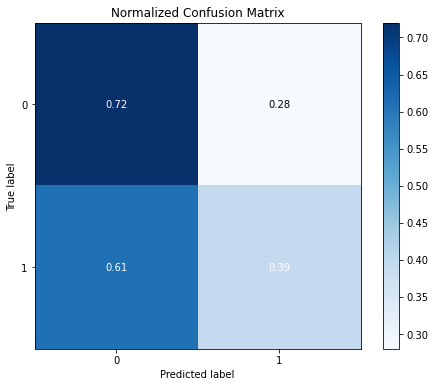

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

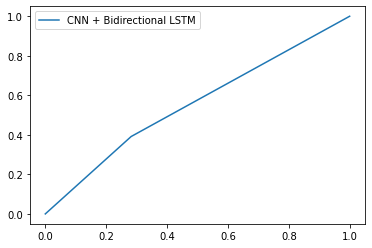

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

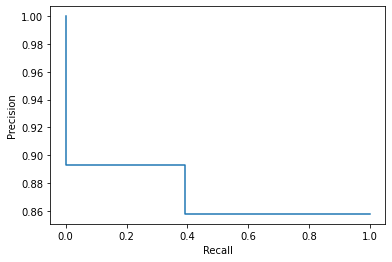

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 1.2 RCNN

Epoch 1/100
22/22 - 3s - loss: 0.7897 - accuracy: 0.5923 - auc_10: 0.6110 - precision_10: 0.5850 - recall_10: 0.5280 - f1_score: 0.6500 - val_loss: 6.6129 - val_accuracy: 0.5190 - val_auc_10: 0.5000 - val_precision_10: 0.5190 - val_recall_10: 1.0000 - val_f1_score: 0.6833 - 3s/epoch - 128ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6598 - accuracy: 0.6648 - auc_10: 0.7122 - precision_10: 0.6528 - recall_10: 0.6490 - f1_score: 0.6500 - val_loss: 1.1907 - val_accuracy: 0.5570 - val_auc_10: 0.5728 - val_precision_10: 0.6500 - val_recall_10: 0.3171 - val_f1_score: 0.6833 - 586ms/epoch - 27ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6222 - accuracy: 0.6889 - auc_10: 0.7483 - precision_10: 0.6863 - recall_10: 0.6519 - f1_score: 0.6500 - val_loss: 4.2403 - val_accuracy: 0.5190 - val_auc_10: 0.5263 - val_precision_10: 0.5190 - val_recall_10: 1.0000 - val_f1_score: 0.6833 - 575ms/epoch - 26ms/step
Epoch 4/100
22/22 - 1s - loss: 0.6389 - accuracy: 0.6548 - auc_10: 0.7285 - precision_10: 0.6437 - recall

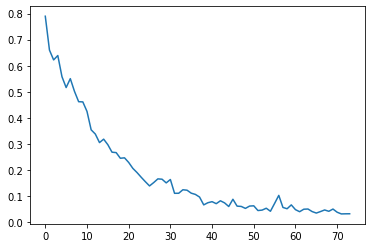

Epoch 1/100
22/22 - 3s - loss: 0.8193 - accuracy: 0.5682 - auc_11: 0.5879 - precision_11: 0.5605 - recall_11: 0.5146 - f1_score: 0.6539 - val_loss: 5.9725 - val_accuracy: 0.4810 - val_auc_11: 0.5000 - val_precision_11: 0.4810 - val_recall_11: 1.0000 - val_f1_score: 0.6496 - 3s/epoch - 140ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6605 - accuracy: 0.6420 - auc_11: 0.6975 - precision_11: 0.6286 - recall_11: 0.6433 - f1_score: 0.6539 - val_loss: 0.9274 - val_accuracy: 0.5190 - val_auc_11: 0.6954 - val_precision_11: 0.5000 - val_recall_11: 0.0263 - val_f1_score: 0.6496 - 580ms/epoch - 26ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6236 - accuracy: 0.6719 - auc_11: 0.7368 - precision_11: 0.6762 - recall_11: 0.6228 - f1_score: 0.6539 - val_loss: 1.5074 - val_accuracy: 0.5063 - val_auc_11: 0.7314 - val_precision_11: 0.4935 - val_recall_11: 1.0000 - val_f1_score: 0.6496 - 579ms/epoch - 26ms/step
Epoch 4/100
22/22 - 1s - loss: 0.6030 - accuracy: 0.6705 - auc_11: 0.7456 - precision_11: 0.6580 - recall

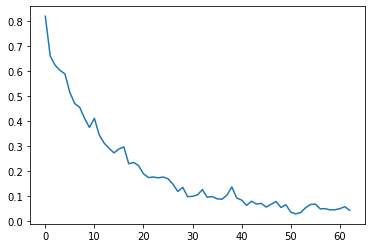

Epoch 1/100
22/22 - 3s - loss: 0.8055 - accuracy: 0.5625 - auc_12: 0.5725 - precision_12: 0.5418 - recall_12: 0.5224 - f1_score: 0.6449 - val_loss: 1.8757 - val_accuracy: 0.4304 - val_auc_12: 0.5255 - val_precision_12: 0.5000 - val_recall_12: 0.0667 - val_f1_score: 0.7258 - 3s/epoch - 124ms/step
Epoch 2/100
22/22 - 1s - loss: 0.6234 - accuracy: 0.6690 - auc_12: 0.7322 - precision_12: 0.6614 - recall_12: 0.6239 - f1_score: 0.6449 - val_loss: 3.6254 - val_accuracy: 0.5696 - val_auc_12: 0.5121 - val_precision_12: 0.5696 - val_recall_12: 1.0000 - val_f1_score: 0.7258 - 580ms/epoch - 26ms/step
Epoch 3/100
22/22 - 1s - loss: 0.5966 - accuracy: 0.7045 - auc_12: 0.7596 - precision_12: 0.6991 - recall_12: 0.6657 - f1_score: 0.6449 - val_loss: 1.1501 - val_accuracy: 0.5190 - val_auc_12: 0.5487 - val_precision_12: 0.6207 - val_recall_12: 0.4000 - val_f1_score: 0.7258 - 580ms/epoch - 26ms/step
Epoch 4/100
22/22 - 1s - loss: 0.6032 - accuracy: 0.6861 - auc_12: 0.7634 - precision_12: 0.6875 - recall

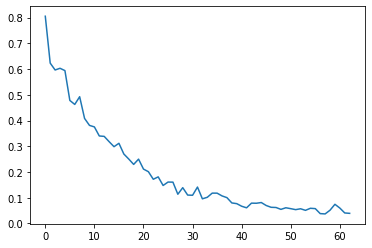

Epoch 1/100
23/23 - 3s - loss: 0.7818 - accuracy: 0.5702 - auc_13: 0.6035 - precision_13: 0.5545 - recall_13: 0.5398 - f1_score: 0.6494 - val_loss: 10.1764 - val_accuracy: 0.4744 - val_auc_13: 0.5000 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.6891 - 3s/epoch - 128ms/step
Epoch 2/100
23/23 - 1s - loss: 0.7068 - accuracy: 0.6270 - auc_13: 0.6778 - precision_13: 0.6275 - recall_13: 0.5516 - f1_score: 0.6494 - val_loss: 7.4935 - val_accuracy: 0.4744 - val_auc_13: 0.5000 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.6891 - 601ms/epoch - 26ms/step
Epoch 3/100
23/23 - 1s - loss: 0.6561 - accuracy: 0.6681 - auc_13: 0.7247 - precision_13: 0.6677 - recall_13: 0.6165 - f1_score: 0.6494 - val_loss: 0.6588 - val_accuracy: 0.6282 - val_auc_13: 0.7169 - val_precision_13: 0.6364 - val_recall_13: 0.6829 - val_f1_score: 0.6891 - 592ms/epoch - 26ms/step
Epoch 4/100
23/23 - 1s - loss: 0.5793 - accuracy: 0.7035 - auc_13: 0.7689 - precision_13

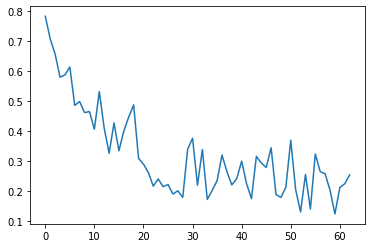

Epoch 1/100
23/23 - 3s - loss: 0.8233 - accuracy: 0.5574 - auc_14: 0.5694 - precision_14: 0.5405 - recall_14: 0.4955 - f1_score: 0.6468 - val_loss: 17.1064 - val_accuracy: 0.5513 - val_auc_14: 0.5000 - val_precision_14: 0.5513 - val_recall_14: 1.0000 - val_f1_score: 0.7107 - 3s/epoch - 139ms/step
Epoch 2/100
23/23 - 1s - loss: 0.7242 - accuracy: 0.6340 - auc_14: 0.6727 - precision_14: 0.6152 - recall_14: 0.6261 - f1_score: 0.6468 - val_loss: 7.2259 - val_accuracy: 0.5513 - val_auc_14: 0.5000 - val_precision_14: 0.5513 - val_recall_14: 1.0000 - val_f1_score: 0.7107 - 591ms/epoch - 26ms/step
Epoch 3/100
23/23 - 1s - loss: 0.6670 - accuracy: 0.6638 - auc_14: 0.7153 - precision_14: 0.6479 - recall_14: 0.6499 - f1_score: 0.6468 - val_loss: 4.9916 - val_accuracy: 0.5513 - val_auc_14: 0.5143 - val_precision_14: 0.5513 - val_recall_14: 1.0000 - val_f1_score: 0.7107 - 601ms/epoch - 26ms/step
Epoch 4/100
23/23 - 1s - loss: 0.6175 - accuracy: 0.6780 - auc_14: 0.7466 - precision_14: 0.6618 - recal

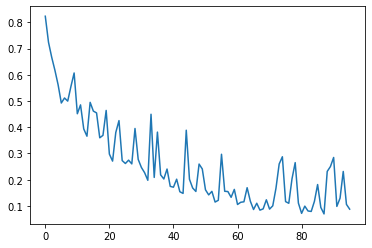

Epoch 1/100
23/23 - 3s - loss: 0.7475 - accuracy: 0.6000 - auc_15: 0.6464 - precision_15: 0.6019 - recall_15: 0.5603 - f1_score: 0.6610 - val_loss: 8.6043 - val_accuracy: 0.4103 - val_auc_15: 0.5000 - val_precision_15: 0.4103 - val_recall_15: 1.0000 - val_f1_score: 0.5818 - 3s/epoch - 125ms/step
Epoch 2/100
23/23 - 1s - loss: 0.7214 - accuracy: 0.6213 - auc_15: 0.6793 - precision_15: 0.6141 - recall_15: 0.6264 - f1_score: 0.6610 - val_loss: 7.7554 - val_accuracy: 0.5897 - val_auc_15: 0.5000 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.5926 - 587ms/epoch - 26ms/step
Epoch 3/100
23/23 - 1s - loss: 0.6428 - accuracy: 0.6993 - auc_15: 0.7470 - precision_15: 0.7099 - recall_15: 0.6609 - f1_score: 0.6610 - val_loss: 1.6006 - val_accuracy: 0.4744 - val_auc_15: 0.6518 - val_precision_15: 0.4384 - val_recall_15: 1.0000 - val_f1_score: 0.5818 - 586ms/epoch - 25ms/step
Epoch 4/100
23/23 - 1s - loss: 0.5917 - accuracy: 0.7035 - auc_15: 0.7658 - precision_15: 0.7026 

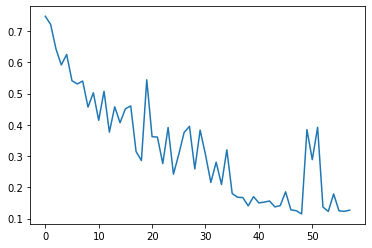

Epoch 1/100
23/23 - 3s - loss: 0.7636 - accuracy: 0.5986 - auc_16: 0.6291 - precision_16: 0.5938 - recall_16: 0.5539 - f1_score: 0.6546 - val_loss: 12.1475 - val_accuracy: 0.4744 - val_auc_16: 0.5000 - val_precision_16: 0.4744 - val_recall_16: 1.0000 - val_f1_score: 0.6435 - 3s/epoch - 124ms/step
Epoch 2/100
23/23 - 1s - loss: 0.6754 - accuracy: 0.6624 - auc_16: 0.7164 - precision_16: 0.6531 - recall_16: 0.6531 - f1_score: 0.6546 - val_loss: 15.7735 - val_accuracy: 0.4744 - val_auc_16: 0.5000 - val_precision_16: 0.4744 - val_recall_16: 1.0000 - val_f1_score: 0.6435 - 581ms/epoch - 25ms/step
Epoch 3/100
23/23 - 1s - loss: 0.6685 - accuracy: 0.6752 - auc_16: 0.7260 - precision_16: 0.6516 - recall_16: 0.7143 - f1_score: 0.6546 - val_loss: 2.6566 - val_accuracy: 0.5256 - val_auc_16: 0.4914 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00 - val_f1_score: 0.6435 - 576ms/epoch - 25ms/step
Epoch 4/100
23/23 - 1s - loss: 0.5967 - accuracy: 0.7106 - auc_16: 0.7707 - precision_16: 0.722

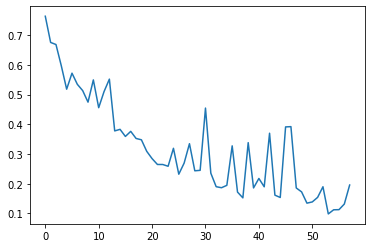

Epoch 1/100
23/23 - 3s - loss: 0.7728 - accuracy: 0.5858 - auc_17: 0.6068 - precision_17: 0.5791 - recall_17: 0.5623 - f1_score: 0.6571 - val_loss: 14.9912 - val_accuracy: 0.4487 - val_auc_17: 0.5000 - val_precision_17: 0.4487 - val_recall_17: 1.0000 - val_f1_score: 0.6195 - 3s/epoch - 127ms/step
Epoch 2/100
23/23 - 1s - loss: 0.7142 - accuracy: 0.6525 - auc_17: 0.6943 - precision_17: 0.6453 - recall_17: 0.6435 - f1_score: 0.6571 - val_loss: 9.4254 - val_accuracy: 0.5513 - val_auc_17: 0.5000 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00 - val_f1_score: 0.6195 - 600ms/epoch - 26ms/step
Epoch 3/100
23/23 - 1s - loss: 0.6592 - accuracy: 0.6738 - auc_17: 0.7308 - precision_17: 0.6861 - recall_17: 0.6145 - f1_score: 0.6571 - val_loss: 11.2905 - val_accuracy: 0.4487 - val_auc_17: 0.5000 - val_precision_17: 0.4487 - val_recall_17: 1.0000 - val_f1_score: 0.6195 - 580ms/epoch - 25ms/step
Epoch 4/100
23/23 - 1s - loss: 0.6573 - accuracy: 0.6965 - auc_17: 0.7417 - precision_17: 0.684

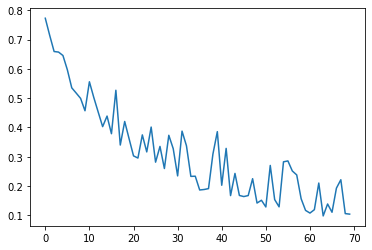

Epoch 1/100
23/23 - 3s - loss: 0.8018 - accuracy: 0.5660 - auc_18: 0.5805 - precision_18: 0.5521 - recall_18: 0.5294 - f1_score: 0.6507 - val_loss: 5.9406 - val_accuracy: 0.5128 - val_auc_18: 0.5000 - val_precision_18: 0.5128 - val_recall_18: 1.0000 - val_f1_score: 0.6780 - 3s/epoch - 123ms/step
Epoch 2/100
23/23 - 1s - loss: 0.6953 - accuracy: 0.6312 - auc_18: 0.6772 - precision_18: 0.6242 - recall_18: 0.5912 - f1_score: 0.6507 - val_loss: 3.4383 - val_accuracy: 0.5128 - val_auc_18: 0.5819 - val_precision_18: 0.5128 - val_recall_18: 1.0000 - val_f1_score: 0.6780 - 561ms/epoch - 24ms/step
Epoch 3/100
23/23 - 1s - loss: 0.6288 - accuracy: 0.6865 - auc_18: 0.7405 - precision_18: 0.6787 - recall_18: 0.6647 - f1_score: 0.6507 - val_loss: 2.7879 - val_accuracy: 0.5128 - val_auc_18: 0.6313 - val_precision_18: 0.5128 - val_recall_18: 1.0000 - val_f1_score: 0.6780 - 570ms/epoch - 25ms/step
Epoch 4/100
23/23 - 1s - loss: 0.5659 - accuracy: 0.7035 - auc_18: 0.7851 - precision_18: 0.6979 - recall

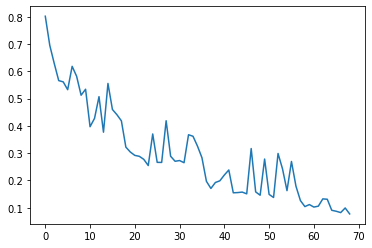

Epoch 1/100
23/23 - 3s - loss: 0.8025 - accuracy: 0.5447 - auc_19: 0.5778 - precision_19: 0.5468 - recall_19: 0.5142 - f1_score: 0.6660 - val_loss: 23.6417 - val_accuracy: 0.3590 - val_auc_19: 0.5000 - val_precision_19: 0.3590 - val_recall_19: 1.0000 - val_f1_score: 0.5283 - 3s/epoch - 127ms/step
Epoch 2/100
23/23 - 1s - loss: 0.6943 - accuracy: 0.6255 - auc_19: 0.6875 - precision_19: 0.6272 - recall_19: 0.6165 - f1_score: 0.6660 - val_loss: 13.8700 - val_accuracy: 0.3590 - val_auc_19: 0.5000 - val_precision_19: 0.3590 - val_recall_19: 1.0000 - val_f1_score: 0.5283 - 608ms/epoch - 26ms/step
Epoch 3/100
23/23 - 1s - loss: 0.6590 - accuracy: 0.6539 - auc_19: 0.7138 - precision_19: 0.6452 - recall_19: 0.6818 - f1_score: 0.6660 - val_loss: 9.8956 - val_accuracy: 0.3590 - val_auc_19: 0.5000 - val_precision_19: 0.3590 - val_recall_19: 1.0000 - val_f1_score: 0.5283 - 597ms/epoch - 26ms/step
Epoch 4/100
23/23 - 1s - loss: 0.6491 - accuracy: 0.6695 - auc_19: 0.7304 - precision_19: 0.6612 - reca

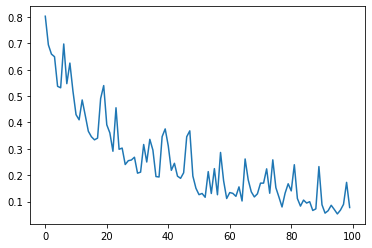

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_body_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_body_model.save(model_path / 'body_binary_rcnn.h5')

#### Training performance

In [ ]:
body_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_rcnn_train_results

{'Accuracy': 0.9641084432601928,
 'ROC/AUC': 0.9917766749858856,
 'Precision': 0.9587255477905273,
 'Recall': 0.9690867483615875,
 'F1-score': 0.6534521996974945}

In [ ]:
body_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
body_rcnn_train_var

{'Accuracy': 0.0007800271894667788,
 'ROC/AUC': 0.00011613985366043522,
 'Precision': 0.0016001449951802723,
 'Recall': 0.0002930554265042318,
 'F1-score': 3.830395711052148e-05}

#### Validation performance

In [ ]:
body_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_rcnn_val_results

{'Accuracy': 0.6664394736289978,
 'ROC/AUC': 0.7326442718505859,
 'Precision': 0.5993120193481445,
 'Recall': 0.6459938704967498,
 'F1-score': 0.6509565472602844}

In [ ]:
body_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
body_rcnn_val_var

{'Accuracy': 0.003095603576768724,
 'ROC/AUC': 0.006473610954477351,
 'Precision': 0.04710543923137735,
 'Recall': 0.05576397216849575,
 'F1-score': 0.003328144293464561}

#### Predictions and performance on test set

In [ ]:
rcnn_binary_body_model = load_model(model_path / 'body_binary_rcnn.h5')
y_pred = rcnn_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_body_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 9ms/step - loss: 1.3722 - accuracy: 0.4380 - auc_10: 0.5987 - precision_10: 0.9010 - recall_10: 0.3872 - f1_score: 0.9234
Accuracy: 43.80% 
ROC/AUC: 0.60 
Precision: 0.90 
Recall: 0.39 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

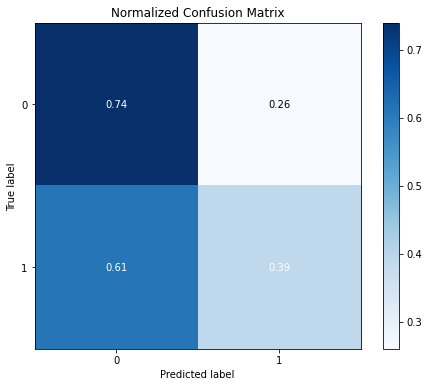

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

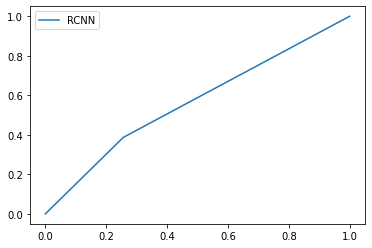

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

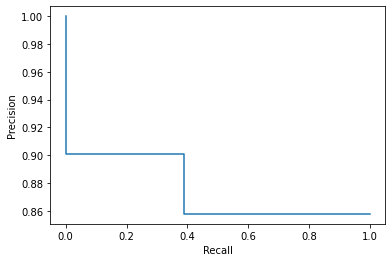

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## 2. Unimodal Face (Facial Expression + Head Pose)

In [ ]:
X_train, X_test, y_train, y_test = load_dataset('AUs', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(752, 1, 350, 25) (752, 1)
(268, 1, 350, 25) (268, 1)


### 2.1 CNN + BiLSTM

Epoch 1/100
22/22 - 10s - loss: 0.6907 - accuracy: 0.5222 - auc_20: 0.5349 - precision_20: 0.5070 - recall_20: 0.3344 - f1_score: 0.6507 - val_loss: 0.6928 - val_accuracy: 0.4737 - val_auc_20: 0.5997 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.6897 - 10s/epoch - 449ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6802 - accuracy: 0.5740 - auc_20: 0.5987 - precision_20: 0.5848 - recall_20: 0.4018 - f1_score: 0.6507 - val_loss: 0.6864 - val_accuracy: 0.5263 - val_auc_20: 0.5639 - val_precision_20: 1.0000 - val_recall_20: 0.1000 - val_f1_score: 0.6897 - 3s/epoch - 114ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6660 - accuracy: 0.6124 - auc_20: 0.6404 - precision_20: 0.6322 - recall_20: 0.4693 - f1_score: 0.6507 - val_loss: 0.6794 - val_accuracy: 0.5263 - val_auc_20: 0.6139 - val_precision_20: 1.0000 - val_recall_20: 0.1000 - val_f1_score: 0.6897 - 3s/epoch - 115ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6594 - accuracy: 0.6169 - auc_20: 0.6416 - precision_20: 0.6356 - 

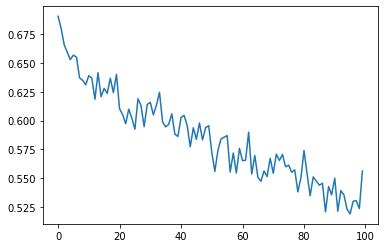

Epoch 1/100
22/22 - 9s - loss: 0.6855 - accuracy: 0.5562 - auc_21: 0.5786 - precision_21: 0.6914 - recall_21: 0.1692 - f1_score: 0.6574 - val_loss: 0.6833 - val_accuracy: 0.4605 - val_auc_21: 0.6927 - val_precision_21: 0.4605 - val_recall_21: 1.0000 - val_f1_score: 0.6306 - 9s/epoch - 430ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6717 - accuracy: 0.5976 - auc_21: 0.6264 - precision_21: 0.5836 - recall_21: 0.6224 - f1_score: 0.6574 - val_loss: 0.6728 - val_accuracy: 0.7105 - val_auc_21: 0.6871 - val_precision_21: 0.7600 - val_recall_21: 0.5429 - val_f1_score: 0.6306 - 3s/epoch - 114ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6606 - accuracy: 0.6139 - auc_21: 0.6430 - precision_21: 0.6182 - recall_21: 0.5529 - f1_score: 0.6574 - val_loss: 0.6913 - val_accuracy: 0.5921 - val_auc_21: 0.6432 - val_precision_21: 0.5370 - val_recall_21: 0.8286 - val_f1_score: 0.6306 - 3s/epoch - 114ms/step
Epoch 4/100
22/22 - 2s - loss: 0.6545 - accuracy: 0.6257 - auc_21: 0.6610 - precision_21: 0.6336 - recall_21:

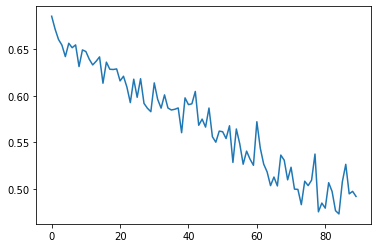

Epoch 1/100
22/22 - 9s - loss: 0.6900 - accuracy: 0.5303 - auc_22: 0.5488 - precision_22: 0.5714 - recall_22: 0.2255 - f1_score: 0.6647 - val_loss: 0.6931 - val_accuracy: 0.5067 - val_auc_22: 0.5000 - val_precision_22: 0.4259 - val_recall_22: 0.7931 - val_f1_score: 0.5577 - 9s/epoch - 428ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6746 - accuracy: 0.5716 - auc_22: 0.6175 - precision_22: 0.5983 - recall_22: 0.4243 - f1_score: 0.6647 - val_loss: 0.7003 - val_accuracy: 0.3867 - val_auc_22: 0.5000 - val_precision_22: 0.3867 - val_recall_22: 1.0000 - val_f1_score: 0.5577 - 3s/epoch - 114ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6764 - accuracy: 0.5835 - auc_22: 0.6021 - precision_22: 0.5952 - recall_22: 0.5104 - f1_score: 0.6647 - val_loss: 0.6889 - val_accuracy: 0.6267 - val_auc_22: 0.5795 - val_precision_22: 1.0000 - val_recall_22: 0.0345 - val_f1_score: 0.5577 - 3s/epoch - 115ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6719 - accuracy: 0.5849 - auc_22: 0.6123 - precision_22: 0.5854 - recall_22:

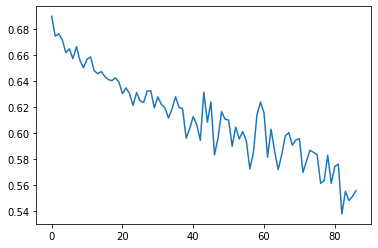

Epoch 1/100
22/22 - 9s - loss: 0.6870 - accuracy: 0.5273 - auc_23: 0.5539 - precision_23: 0.5152 - recall_23: 0.6114 - f1_score: 0.6581 - val_loss: 0.6911 - val_accuracy: 0.5467 - val_auc_23: 0.5086 - val_precision_23: 0.5000 - val_recall_23: 0.0588 - val_f1_score: 0.6239 - 9s/epoch - 426ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6657 - accuracy: 0.6012 - auc_23: 0.6362 - precision_23: 0.6115 - recall_23: 0.5120 - f1_score: 0.6581 - val_loss: 0.7011 - val_accuracy: 0.4533 - val_auc_23: 0.4835 - val_precision_23: 0.4533 - val_recall_23: 1.0000 - val_f1_score: 0.6239 - 3s/epoch - 114ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6563 - accuracy: 0.6248 - auc_23: 0.6545 - precision_23: 0.6060 - recall_23: 0.6717 - f1_score: 0.6581 - val_loss: 0.7040 - val_accuracy: 0.4533 - val_auc_23: 0.5086 - val_precision_23: 0.4533 - val_recall_23: 1.0000 - val_f1_score: 0.6239 - 3s/epoch - 114ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6559 - accuracy: 0.6233 - auc_23: 0.6570 - precision_23: 0.6072 - recall_23:

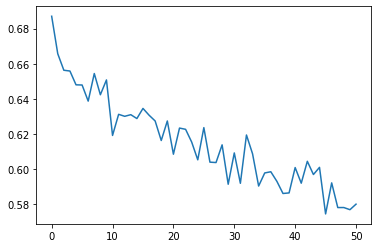

Epoch 1/100
22/22 - 9s - loss: 0.6931 - accuracy: 0.4948 - auc_24: 0.4988 - precision_24: 0.4503 - recall_24: 0.2663 - f1_score: 0.6460 - val_loss: 0.6931 - val_accuracy: 0.4400 - val_auc_24: 0.5876 - val_precision_24: 0.6667 - val_recall_24: 0.0465 - val_f1_score: 0.7288 - 9s/epoch - 428ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6739 - accuracy: 0.5820 - auc_24: 0.6163 - precision_24: 0.5917 - recall_24: 0.3994 - f1_score: 0.6460 - val_loss: 0.6889 - val_accuracy: 0.6267 - val_auc_24: 0.5719 - val_precision_24: 0.6364 - val_recall_24: 0.8140 - val_f1_score: 0.7288 - 3s/epoch - 115ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6675 - accuracy: 0.5894 - auc_24: 0.6239 - precision_24: 0.5768 - recall_24: 0.5232 - f1_score: 0.6460 - val_loss: 0.6831 - val_accuracy: 0.5467 - val_auc_24: 0.5807 - val_precision_24: 0.6000 - val_recall_24: 0.6279 - val_f1_score: 0.7288 - 3s/epoch - 115ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6558 - accuracy: 0.6278 - auc_24: 0.6538 - precision_24: 0.6203 - recall_24:

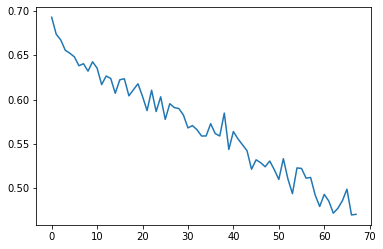

Epoch 1/100
22/22 - 9s - loss: 0.6900 - accuracy: 0.5391 - auc_25: 0.5422 - precision_25: 0.5494 - recall_25: 0.2713 - f1_score: 0.6527 - val_loss: 0.6909 - val_accuracy: 0.5067 - val_auc_25: 0.6142 - val_precision_25: 0.5067 - val_recall_25: 1.0000 - val_f1_score: 0.6726 - 9s/epoch - 426ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6764 - accuracy: 0.5820 - auc_25: 0.6007 - precision_25: 0.5758 - recall_25: 0.5213 - f1_score: 0.6527 - val_loss: 0.6889 - val_accuracy: 0.5600 - val_auc_25: 0.6038 - val_precision_25: 0.5532 - val_recall_25: 0.6842 - val_f1_score: 0.6726 - 3s/epoch - 116ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6690 - accuracy: 0.5923 - auc_25: 0.6231 - precision_25: 0.5929 - recall_25: 0.5061 - f1_score: 0.6527 - val_loss: 0.6806 - val_accuracy: 0.6267 - val_auc_25: 0.6543 - val_precision_25: 0.6316 - val_recall_25: 0.6316 - val_f1_score: 0.6726 - 3s/epoch - 115ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6647 - accuracy: 0.6130 - auc_25: 0.6338 - precision_25: 0.6146 - recall_25:

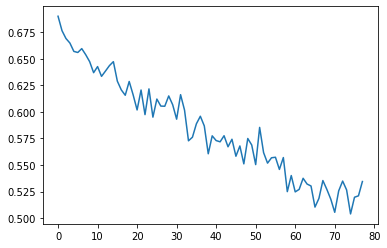

Epoch 1/100
22/22 - 9s - loss: 0.6870 - accuracy: 0.5406 - auc_26: 0.5703 - precision_26: 0.5244 - recall_26: 0.7087 - f1_score: 0.6594 - val_loss: 0.6902 - val_accuracy: 0.6000 - val_auc_26: 0.5960 - val_precision_26: 0.8000 - val_recall_26: 0.1212 - val_f1_score: 0.6111 - 9s/epoch - 401ms/step
Epoch 2/100
22/22 - 2s - loss: 0.6709 - accuracy: 0.5997 - auc_26: 0.6079 - precision_26: 0.6566 - recall_26: 0.3904 - f1_score: 0.6594 - val_loss: 0.6929 - val_accuracy: 0.4400 - val_auc_26: 0.6111 - val_precision_26: 0.4400 - val_recall_26: 1.0000 - val_f1_score: 0.6111 - 2s/epoch - 104ms/step
Epoch 3/100
22/22 - 2s - loss: 0.6684 - accuracy: 0.5849 - auc_26: 0.6215 - precision_26: 0.5833 - recall_26: 0.5465 - f1_score: 0.6594 - val_loss: 0.6825 - val_accuracy: 0.5733 - val_auc_26: 0.6685 - val_precision_26: 1.0000 - val_recall_26: 0.0303 - val_f1_score: 0.6111 - 2s/epoch - 105ms/step
Epoch 4/100
22/22 - 2s - loss: 0.6531 - accuracy: 0.6396 - auc_26: 0.6520 - precision_26: 0.6802 - recall_26:

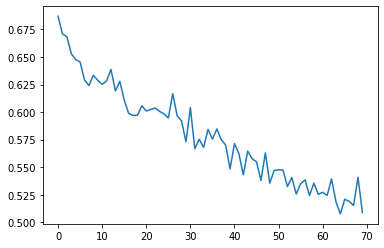

Epoch 1/100
22/22 - 9s - loss: 0.6888 - accuracy: 0.5347 - auc_27: 0.5416 - precision_27: 0.5234 - recall_27: 0.4098 - f1_score: 0.6514 - val_loss: 0.6904 - val_accuracy: 0.5200 - val_auc_27: 0.5043 - val_precision_27: 0.5217 - val_recall_27: 0.9231 - val_f1_score: 0.6842 - 9s/epoch - 424ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6608 - accuracy: 0.6130 - auc_27: 0.6447 - precision_27: 0.6087 - recall_27: 0.5566 - f1_score: 0.6514 - val_loss: 0.6920 - val_accuracy: 0.4800 - val_auc_27: 0.5192 - val_precision_27: 0.5000 - val_recall_27: 0.1282 - val_f1_score: 0.6842 - 3s/epoch - 115ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6535 - accuracy: 0.6278 - auc_27: 0.6538 - precision_27: 0.6506 - recall_27: 0.4954 - f1_score: 0.6514 - val_loss: 0.6929 - val_accuracy: 0.4800 - val_auc_27: 0.5089 - val_precision_27: 0.5000 - val_recall_27: 0.7436 - val_f1_score: 0.6842 - 3s/epoch - 114ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6483 - accuracy: 0.6322 - auc_27: 0.6686 - precision_27: 0.6291 - recall_27:

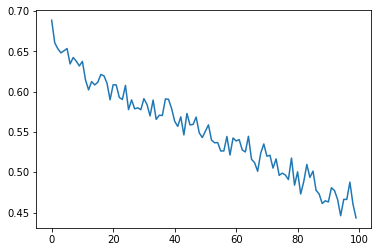

Epoch 1/100
22/22 - 9s - loss: 0.6923 - accuracy: 0.5229 - auc_28: 0.5205 - precision_28: 0.5085 - recall_28: 0.4573 - f1_score: 0.6527 - val_loss: 0.6892 - val_accuracy: 0.5333 - val_auc_28: 0.5711 - val_precision_28: 0.8000 - val_recall_28: 0.1053 - val_f1_score: 0.6726 - 9s/epoch - 422ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6770 - accuracy: 0.5820 - auc_28: 0.6080 - precision_28: 0.6047 - recall_28: 0.3963 - f1_score: 0.6527 - val_loss: 0.6870 - val_accuracy: 0.5333 - val_auc_28: 0.5683 - val_precision_28: 0.8000 - val_recall_28: 0.1053 - val_f1_score: 0.6726 - 3s/epoch - 115ms/step
Epoch 3/100
22/22 - 2s - loss: 0.6690 - accuracy: 0.5908 - auc_28: 0.6242 - precision_28: 0.6164 - recall_28: 0.4116 - f1_score: 0.6527 - val_loss: 0.6875 - val_accuracy: 0.4933 - val_auc_28: 0.5092 - val_precision_28: 0.5000 - val_recall_28: 0.2105 - val_f1_score: 0.6726 - 2s/epoch - 114ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6862 - accuracy: 0.5303 - auc_28: 0.5596 - precision_28: 0.5146 - recall_28:

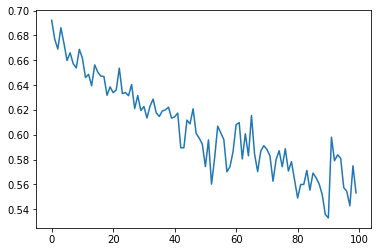

Epoch 1/100
22/22 - 9s - loss: 0.6825 - accuracy: 0.5687 - auc_29: 0.5955 - precision_29: 0.5631 - recall_29: 0.5015 - f1_score: 0.6541 - val_loss: 0.6963 - val_accuracy: 0.5200 - val_auc_29: 0.4975 - val_precision_29: 0.5068 - val_recall_29: 1.0000 - val_f1_score: 0.6607 - 9s/epoch - 429ms/step
Epoch 2/100
22/22 - 2s - loss: 0.6631 - accuracy: 0.6086 - auc_29: 0.6445 - precision_29: 0.6203 - recall_29: 0.5015 - f1_score: 0.6541 - val_loss: 0.7060 - val_accuracy: 0.5333 - val_auc_29: 0.5046 - val_precision_29: 0.5152 - val_recall_29: 0.9189 - val_f1_score: 0.6607 - 2s/epoch - 113ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6432 - accuracy: 0.6307 - auc_29: 0.6782 - precision_29: 0.6231 - recall_29: 0.6079 - f1_score: 0.6541 - val_loss: 0.7099 - val_accuracy: 0.4800 - val_auc_29: 0.5199 - val_precision_29: 0.4865 - val_recall_29: 0.9730 - val_f1_score: 0.6607 - 3s/epoch - 114ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6297 - accuracy: 0.6736 - auc_29: 0.7007 - precision_29: 0.6646 - recall_29:

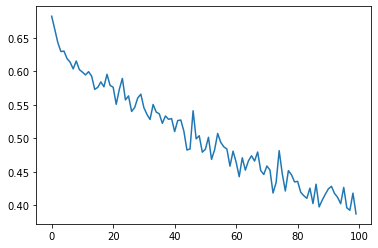

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_face_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_face_model.save(model_path / 'face_binary_cnnlstm.h5')

#### Training performance

In [ ]:
face_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_cnnlstm_train_results

{'Accuracy': 0.7378809750080109,
 'ROC/AUC': 0.8201607406139374,
 'Precision': 0.7618657231330872,
 'Recall': 0.6736832439899445,
 'F1-score': 0.6547216892242431}

In [ ]:
face_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
face_cnnlstm_train_var

{'Accuracy': 0.0015315450441898194,
 'ROC/AUC': 0.001978039983374522,
 'Precision': 0.00212626665884045,
 'Recall': 0.0027198177128397913,
 'F1-score': 2.5144348339125602e-05}

#### Validation performance

In [ ]:
face_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_cnnlstm_val_results

{'Accuracy': 0.5585964888334274,
 'ROC/AUC': 0.6281813949346542,
 'Precision': 0.5501037061214447,
 'Recall': 0.6536248534917831,
 'F1-score': 0.6531813502311706}

In [ ]:
face_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
face_cnnlstm_val_var

{'Accuracy': 0.0050918868773416025,
 'ROC/AUC': 0.0055889936293337505,
 'Precision': 0.00913289332566997,
 'Recall': 0.01347625340594157,
 'F1-score': 0.002107843036809385}

#### Predictions and performance on test set

In [ ]:
cnnlstm_binary_face_model = load_model(model_path / 'face_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_face_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 2s 33ms/step - loss: 0.6777 - accuracy: 0.5858 - auc_20: 0.6467 - precision_20: 0.9348 - recall_20: 0.5584 - f1_score: 0.9259
Accuracy: 58.58% 
ROC/AUC: 0.65 
Precision: 0.93 
Recall: 0.56 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

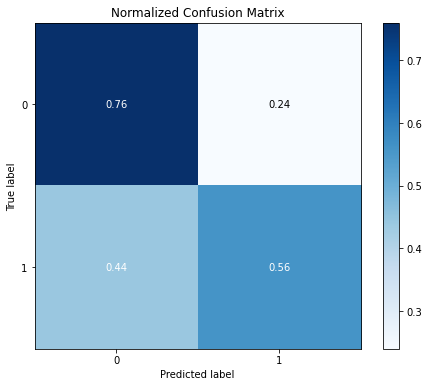

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

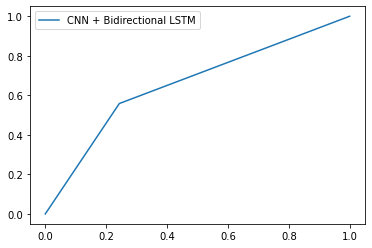

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

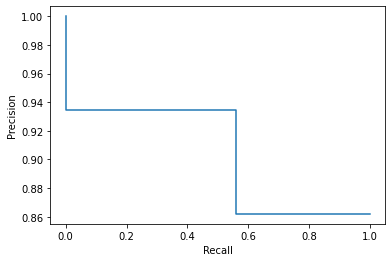

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 2.2 RCNN

Epoch 1/100
22/22 - 3s - loss: 0.8259 - accuracy: 0.5385 - auc_30: 0.5443 - precision_30: 0.5180 - recall_30: 0.6166 - f1_score: 0.6507 - val_loss: 0.6569 - val_accuracy: 0.5263 - val_auc_30: 0.5625 - val_precision_30: 0.5263 - val_recall_30: 1.0000 - val_f1_score: 0.6897 - 3s/epoch - 132ms/step
Epoch 2/100
22/22 - 1s - loss: 0.8196 - accuracy: 0.5695 - auc_30: 0.5784 - precision_30: 0.5570 - recall_30: 0.5245 - f1_score: 0.6507 - val_loss: 0.6593 - val_accuracy: 0.5263 - val_auc_30: 0.5500 - val_precision_30: 0.5263 - val_recall_30: 1.0000 - val_f1_score: 0.6897 - 557ms/epoch - 25ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7596 - accuracy: 0.5296 - auc_30: 0.5577 - precision_30: 0.5101 - recall_30: 0.6196 - f1_score: 0.6507 - val_loss: 0.6573 - val_accuracy: 0.5263 - val_auc_30: 0.6625 - val_precision_30: 0.5263 - val_recall_30: 1.0000 - val_f1_score: 0.6897 - 550ms/epoch - 25ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7762 - accuracy: 0.5651 - auc_30: 0.5909 - precision_30: 0.5588 - recall

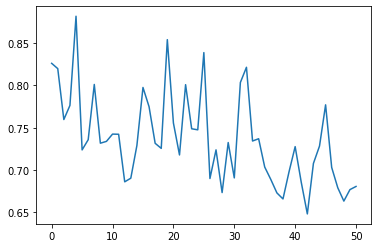

Epoch 1/100
22/22 - 3s - loss: 0.7808 - accuracy: 0.5222 - auc_31: 0.5513 - precision_31: 0.5133 - recall_31: 0.4653 - f1_score: 0.6574 - val_loss: 0.7092 - val_accuracy: 0.5263 - val_auc_31: 0.6021 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_f1_score: 0.6306 - 3s/epoch - 131ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7559 - accuracy: 0.5429 - auc_31: 0.5672 - precision_31: 0.5367 - recall_31: 0.4864 - f1_score: 0.6574 - val_loss: 0.7108 - val_accuracy: 0.5263 - val_auc_31: 0.4484 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_f1_score: 0.6306 - 558ms/epoch - 25ms/step
Epoch 3/100
22/22 - 1s - loss: 0.8034 - accuracy: 0.5340 - auc_31: 0.5949 - precision_31: 0.5513 - recall_31: 0.2598 - f1_score: 0.6574 - val_loss: 0.6971 - val_accuracy: 0.4737 - val_auc_31: 0.6038 - val_precision_31: 0.4667 - val_recall_31: 1.0000 - val_f1_score: 0.6306 - 555ms/epoch - 25ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7781 - accuracy: 0.5503 - auc_31: 0.5623 - precision_31:

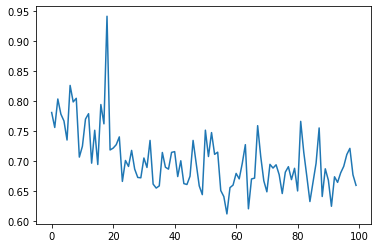

Epoch 1/100
22/22 - 3s - loss: 0.8473 - accuracy: 0.5052 - auc_32: 0.5212 - precision_32: 0.5022 - recall_32: 0.6884 - f1_score: 0.6647 - val_loss: 0.6955 - val_accuracy: 0.3867 - val_auc_32: 0.5000 - val_precision_32: 0.3867 - val_recall_32: 1.0000 - val_f1_score: 0.5577 - 3s/epoch - 132ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7676 - accuracy: 0.5288 - auc_32: 0.5634 - precision_32: 0.5260 - recall_32: 0.5401 - f1_score: 0.6647 - val_loss: 0.6978 - val_accuracy: 0.3867 - val_auc_32: 0.5000 - val_precision_32: 0.3867 - val_recall_32: 1.0000 - val_f1_score: 0.5577 - 531ms/epoch - 24ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7953 - accuracy: 0.5510 - auc_32: 0.5807 - precision_32: 0.5398 - recall_32: 0.6647 - f1_score: 0.6647 - val_loss: 0.7429 - val_accuracy: 0.3867 - val_auc_32: 0.5000 - val_precision_32: 0.3867 - val_recall_32: 1.0000 - val_f1_score: 0.5577 - 526ms/epoch - 24ms/step
Epoch 4/100
22/22 - 1s - loss: 0.8273 - accuracy: 0.5332 - auc_32: 0.5493 - precision_32: 0.5315 - recall

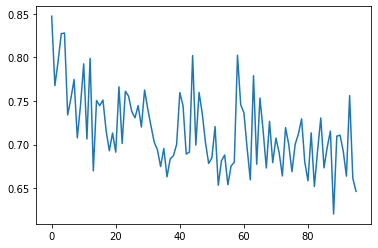

Epoch 1/100
22/22 - 3s - loss: 0.8166 - accuracy: 0.5126 - auc_33: 0.5368 - precision_33: 0.5036 - recall_33: 0.4247 - f1_score: 0.6581 - val_loss: 0.8230 - val_accuracy: 0.4533 - val_auc_33: 0.5506 - val_precision_33: 0.4521 - val_recall_33: 0.9706 - val_f1_score: 0.6239 - 3s/epoch - 125ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7369 - accuracy: 0.5687 - auc_33: 0.6064 - precision_33: 0.5503 - recall_33: 0.6596 - f1_score: 0.6581 - val_loss: 1.3131 - val_accuracy: 0.5467 - val_auc_33: 0.5319 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00 - val_f1_score: 0.6111 - 513ms/epoch - 23ms/step
Epoch 3/100
22/22 - 1s - loss: 0.8113 - accuracy: 0.5465 - auc_33: 0.5771 - precision_33: 0.5392 - recall_33: 0.5181 - f1_score: 0.6581 - val_loss: 0.7897 - val_accuracy: 0.4667 - val_auc_33: 0.5283 - val_precision_33: 0.4595 - val_recall_33: 1.0000 - val_f1_score: 0.6239 - 527ms/epoch - 24ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7638 - accuracy: 0.5052 - auc_33: 0.5410 - precision_33: 0.4967 

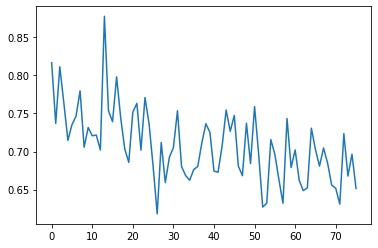

Epoch 1/100
22/22 - 3s - loss: 0.8059 - accuracy: 0.5406 - auc_34: 0.5364 - precision_34: 0.5213 - recall_34: 0.4551 - f1_score: 0.6460 - val_loss: 0.7894 - val_accuracy: 0.5600 - val_auc_34: 0.5051 - val_precision_34: 0.5676 - val_recall_34: 0.9767 - val_f1_score: 0.7288 - 3s/epoch - 124ms/step
Epoch 2/100
22/22 - 1s - loss: 0.8049 - accuracy: 0.5318 - auc_34: 0.5478 - precision_34: 0.5105 - recall_34: 0.4520 - f1_score: 0.6460 - val_loss: 1.3342 - val_accuracy: 0.4267 - val_auc_34: 0.4767 - val_precision_34: 0.0000e+00 - val_recall_34: 0.0000e+00 - val_f1_score: 0.7179 - 520ms/epoch - 24ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7755 - accuracy: 0.5318 - auc_34: 0.5527 - precision_34: 0.5088 - recall_34: 0.5387 - f1_score: 0.6460 - val_loss: 0.6681 - val_accuracy: 0.5733 - val_auc_34: 0.5200 - val_precision_34: 0.5733 - val_recall_34: 1.0000 - val_f1_score: 0.7288 - 526ms/epoch - 24ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7590 - accuracy: 0.5657 - auc_34: 0.5859 - precision_34: 0.5539 

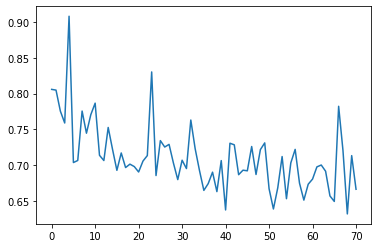

Epoch 1/100
22/22 - 3s - loss: 0.7973 - accuracy: 0.5096 - auc_35: 0.5148 - precision_35: 0.4928 - recall_35: 0.4177 - f1_score: 0.6527 - val_loss: 0.8729 - val_accuracy: 0.5067 - val_auc_35: 0.5000 - val_precision_35: 1.0000 - val_recall_35: 0.0263 - val_f1_score: 0.6726 - 3s/epoch - 138ms/step
Epoch 2/100
22/22 - 1s - loss: 0.8919 - accuracy: 0.5126 - auc_35: 0.5147 - precision_35: 0.4969 - recall_35: 0.4848 - f1_score: 0.6527 - val_loss: 0.6792 - val_accuracy: 0.5200 - val_auc_35: 0.5263 - val_precision_35: 1.0000 - val_recall_35: 0.0526 - val_f1_score: 0.6726 - 541ms/epoch - 25ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7151 - accuracy: 0.5554 - auc_35: 0.5775 - precision_35: 0.5517 - recall_35: 0.4390 - f1_score: 0.6527 - val_loss: 0.8388 - val_accuracy: 0.4933 - val_auc_35: 0.5295 - val_precision_35: 0.0000e+00 - val_recall_35: 0.0000e+00 - val_f1_score: 0.6726 - 512ms/epoch - 23ms/step
Epoch 4/100
22/22 - 1s - loss: 0.6859 - accuracy: 0.5613 - auc_35: 0.6083 - precision_35: 0.5407 

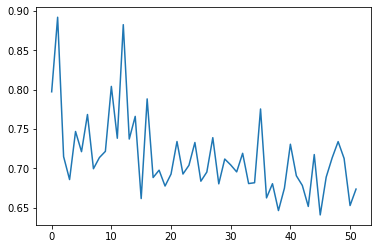

Epoch 1/100
22/22 - 3s - loss: 0.8135 - accuracy: 0.5258 - auc_36: 0.5228 - precision_36: 0.5231 - recall_36: 0.4084 - f1_score: 0.6594 - val_loss: 0.6931 - val_accuracy: 0.4533 - val_auc_36: 0.5065 - val_precision_36: 0.4429 - val_recall_36: 0.9394 - val_f1_score: 0.6111 - 3s/epoch - 123ms/step
Epoch 2/100
22/22 - 1s - loss: 0.8002 - accuracy: 0.5465 - auc_36: 0.5762 - precision_36: 0.5516 - recall_36: 0.4174 - f1_score: 0.6594 - val_loss: 0.6860 - val_accuracy: 0.5600 - val_auc_36: 0.5000 - val_precision_36: 0.0000e+00 - val_recall_36: 0.0000e+00 - val_f1_score: 0.6111 - 534ms/epoch - 24ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7967 - accuracy: 0.5362 - auc_36: 0.5604 - precision_36: 0.5537 - recall_36: 0.2943 - f1_score: 0.6594 - val_loss: 0.7166 - val_accuracy: 0.4400 - val_auc_36: 0.5238 - val_precision_36: 0.4400 - val_recall_36: 1.0000 - val_f1_score: 0.6111 - 510ms/epoch - 23ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7596 - accuracy: 0.5288 - auc_36: 0.5298 - precision_36: 0.5180 

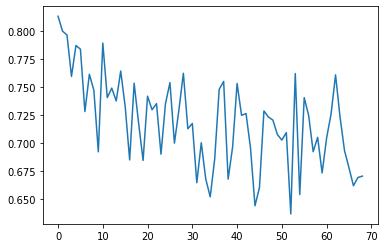

Epoch 1/100
22/22 - 3s - loss: 0.8222 - accuracy: 0.5288 - auc_37: 0.5402 - precision_37: 0.5233 - recall_37: 0.2752 - f1_score: 0.6514 - val_loss: 0.9270 - val_accuracy: 0.4933 - val_auc_37: 0.5135 - val_precision_37: 1.0000 - val_recall_37: 0.0256 - val_f1_score: 0.6842 - 3s/epoch - 131ms/step
Epoch 2/100
22/22 - 1s - loss: 0.8044 - accuracy: 0.4948 - auc_37: 0.4948 - precision_37: 0.4784 - recall_37: 0.5076 - f1_score: 0.6514 - val_loss: 1.2480 - val_accuracy: 0.4800 - val_auc_37: 0.4758 - val_precision_37: 0.0000e+00 - val_recall_37: 0.0000e+00 - val_f1_score: 0.6842 - 570ms/epoch - 26ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7132 - accuracy: 0.5583 - auc_37: 0.5877 - precision_37: 0.5619 - recall_37: 0.3884 - f1_score: 0.6514 - val_loss: 0.7961 - val_accuracy: 0.4933 - val_auc_37: 0.5135 - val_precision_37: 1.0000 - val_recall_37: 0.0256 - val_f1_score: 0.6842 - 583ms/epoch - 26ms/step
Epoch 4/100
22/22 - 1s - loss: 0.6969 - accuracy: 0.5805 - auc_37: 0.6196 - precision_37: 0.5956 

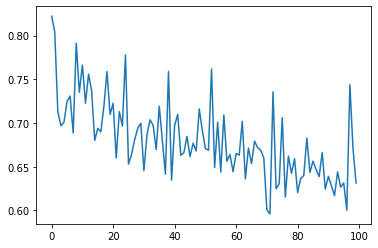

Epoch 1/100
22/22 - 3s - loss: 0.8191 - accuracy: 0.5052 - auc_38: 0.5082 - precision_38: 0.4896 - recall_38: 0.5030 - f1_score: 0.6527 - val_loss: 0.7744 - val_accuracy: 0.5067 - val_auc_38: 0.5754 - val_precision_38: 0.5067 - val_recall_38: 1.0000 - val_f1_score: 0.6726 - 3s/epoch - 133ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7454 - accuracy: 0.5465 - auc_38: 0.5591 - precision_38: 0.5344 - recall_38: 0.4970 - f1_score: 0.6527 - val_loss: 0.8187 - val_accuracy: 0.5067 - val_auc_38: 0.6558 - val_precision_38: 0.5067 - val_recall_38: 1.0000 - val_f1_score: 0.6726 - 550ms/epoch - 25ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7684 - accuracy: 0.5037 - auc_38: 0.5345 - precision_38: 0.4910 - recall_38: 0.6646 - f1_score: 0.6527 - val_loss: 1.0464 - val_accuracy: 0.4800 - val_auc_38: 0.4872 - val_precision_38: 0.4932 - val_recall_38: 0.9474 - val_f1_score: 0.6726 - 553ms/epoch - 25ms/step
Epoch 4/100
22/22 - 1s - loss: 0.6776 - accuracy: 0.5687 - auc_38: 0.6312 - precision_38: 0.5526 - recall

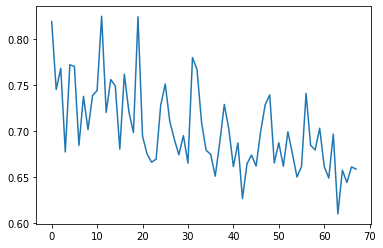

Epoch 1/100
22/22 - 3s - loss: 0.8449 - accuracy: 0.4904 - auc_39: 0.4931 - precision_39: 0.4724 - recall_39: 0.4164 - f1_score: 0.6541 - val_loss: 0.6975 - val_accuracy: 0.4933 - val_auc_39: 0.4737 - val_precision_39: 0.4933 - val_recall_39: 1.0000 - val_f1_score: 0.6607 - 3s/epoch - 146ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7472 - accuracy: 0.5569 - auc_39: 0.5731 - precision_39: 0.5452 - recall_39: 0.5319 - f1_score: 0.6541 - val_loss: 0.6879 - val_accuracy: 0.5067 - val_auc_39: 0.5132 - val_precision_39: 0.5000 - val_recall_39: 1.0000 - val_f1_score: 0.6607 - 564ms/epoch - 26ms/step
Epoch 3/100
22/22 - 1s - loss: 0.8134 - accuracy: 0.4904 - auc_39: 0.5058 - precision_39: 0.4804 - recall_39: 0.5957 - f1_score: 0.6541 - val_loss: 0.6865 - val_accuracy: 0.5067 - val_auc_39: 0.5132 - val_precision_39: 0.5000 - val_recall_39: 1.0000 - val_f1_score: 0.6607 - 558ms/epoch - 25ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7164 - accuracy: 0.5258 - auc_39: 0.5916 - precision_39: 0.5299 - recall

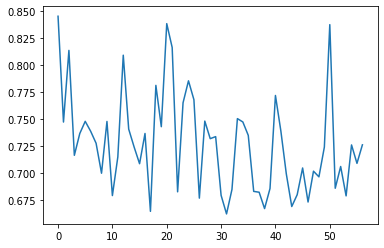

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_face_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_face_model.save(model_path / 'face_binary_rcnn.h5')

#### Training performance

In [ ]:
face_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_rcnn_train_results

{'Accuracy': 0.5923437476158142,
 'ROC/AUC': 0.6521167278289794,
 'Precision': 0.6253135621547699,
 'Recall': 0.4625202536582947,
 'F1-score': 0.6547216892242431}

In [ ]:
face_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
face_rcnn_train_var

{'Accuracy': 0.0002946976096367848,
 'ROC/AUC': 0.000571453327036977,
 'Precision': 0.003936788021889051,
 'Recall': 0.019951301661563683,
 'F1-score': 2.5144348339125602e-05}

#### Validation performance

In [ ]:
face_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_rcnn_val_results

{'Accuracy': 0.4799824595451355,
 'ROC/AUC': 0.5521213948726654,
 'Precision': 0.5319108545780182,
 'Recall': 0.9020195819437504,
 'F1-score': 0.6531813502311706}

In [ ]:
face_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
face_rcnn_val_var

{'Accuracy': 0.0017836413630419302,
 'ROC/AUC': 0.002672776784708084,
 'Precision': 0.026010284311314753,
 'Recall': 0.08138309745885322,
 'F1-score': 0.002107843036809385}

#### Predictions and performance on test set

In [ ]:
rcnn_binary_face_model = load_model(model_path / 'face_binary_rcnn.h5')
y_pred = rcnn_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_face_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 9ms/step - loss: 0.6584 - accuracy: 0.8619 - auc_34: 0.4686 - precision_34: 0.8619 - recall_34: 1.0000 - f1_score: 0.9259
Accuracy: 86.19% 
ROC/AUC: 0.47 
Precision: 0.86 
Recall: 1.00 
F1 score: 0.93


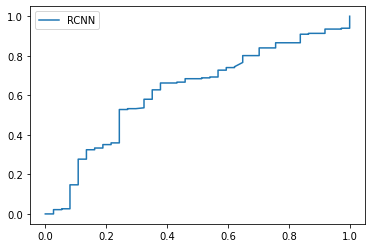

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

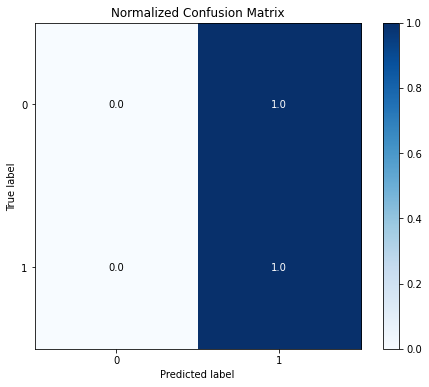

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

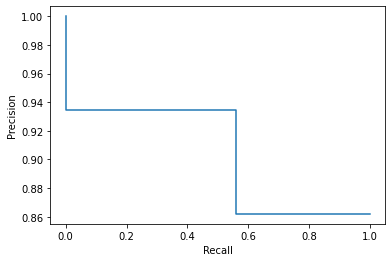

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp.plot()

## 3. Multimodal Early Fusion

In [ ]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(752, 1, 350, 60) (752, 1)
(268, 1, 350, 60) (268, 1)


### 3.1 CNN + BiLSTM

Epoch 1/100
22/22 - 10s - loss: 0.6845 - accuracy: 0.5621 - auc_40: 0.5790 - precision_40: 0.5605 - recall_40: 0.4264 - f1_score: 0.6507 - val_loss: 0.6839 - val_accuracy: 0.5263 - val_auc_40: 0.7302 - val_precision_40: 0.5263 - val_recall_40: 1.0000 - val_f1_score: 0.6897 - 10s/epoch - 443ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6564 - accuracy: 0.6169 - auc_40: 0.6519 - precision_40: 0.6113 - recall_40: 0.5644 - f1_score: 0.6507 - val_loss: 0.6756 - val_accuracy: 0.5263 - val_auc_40: 0.6660 - val_precision_40: 0.5263 - val_recall_40: 1.0000 - val_f1_score: 0.6897 - 3s/epoch - 115ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6496 - accuracy: 0.6169 - auc_40: 0.6640 - precision_40: 0.6218 - recall_40: 0.5245 - f1_score: 0.6507 - val_loss: 0.6852 - val_accuracy: 0.5263 - val_auc_40: 0.5139 - val_precision_40: 0.5357 - val_recall_40: 0.7500 - val_f1_score: 0.6897 - 3s/epoch - 114ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6312 - accuracy: 0.6672 - auc_40: 0.6961 - precision_40: 0.6784 - recall_4

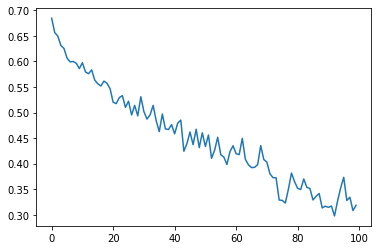

Epoch 1/100
22/22 - 10s - loss: 0.6846 - accuracy: 0.5577 - auc_41: 0.5723 - precision_41: 0.5548 - recall_41: 0.4894 - f1_score: 0.6574 - val_loss: 0.7043 - val_accuracy: 0.5263 - val_auc_41: 0.5289 - val_precision_41: 0.4925 - val_recall_41: 0.9429 - val_f1_score: 0.6306 - 10s/epoch - 446ms/step
Epoch 2/100
22/22 - 2s - loss: 0.6594 - accuracy: 0.6139 - auc_41: 0.6483 - precision_41: 0.6215 - recall_41: 0.5408 - f1_score: 0.6574 - val_loss: 0.6992 - val_accuracy: 0.5395 - val_auc_41: 0.4390 - val_precision_41: 0.5000 - val_recall_41: 0.1714 - val_f1_score: 0.6306 - 2s/epoch - 113ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6392 - accuracy: 0.6391 - auc_41: 0.6820 - precision_41: 0.6526 - recall_41: 0.5619 - f1_score: 0.6574 - val_loss: 0.7133 - val_accuracy: 0.4605 - val_auc_41: 0.4718 - val_precision_41: 0.4605 - val_recall_41: 1.0000 - val_f1_score: 0.6306 - 3s/epoch - 115ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6254 - accuracy: 0.6568 - auc_41: 0.7059 - precision_41: 0.6542 - recall_4

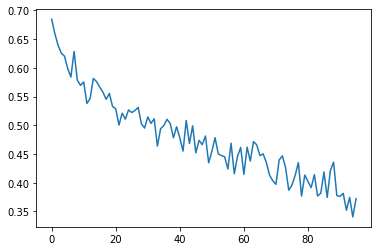

Epoch 1/100
22/22 - 10s - loss: 0.6848 - accuracy: 0.5643 - auc_42: 0.5820 - precision_42: 0.5729 - recall_42: 0.4896 - f1_score: 0.6647 - val_loss: 0.7047 - val_accuracy: 0.3867 - val_auc_42: 0.6169 - val_precision_42: 0.3867 - val_recall_42: 1.0000 - val_f1_score: 0.5577 - 10s/epoch - 448ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6605 - accuracy: 0.6263 - auc_42: 0.6601 - precision_42: 0.6105 - recall_42: 0.6884 - f1_score: 0.6647 - val_loss: 0.7062 - val_accuracy: 0.3867 - val_auc_42: 0.5753 - val_precision_42: 0.3867 - val_recall_42: 1.0000 - val_f1_score: 0.5577 - 3s/epoch - 116ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6350 - accuracy: 0.6411 - auc_42: 0.6915 - precision_42: 0.6497 - recall_42: 0.6053 - f1_score: 0.6647 - val_loss: 0.6943 - val_accuracy: 0.5067 - val_auc_42: 0.5142 - val_precision_42: 0.4091 - val_recall_42: 0.6207 - val_f1_score: 0.5577 - 3s/epoch - 116ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6185 - accuracy: 0.6691 - auc_42: 0.7172 - precision_42: 0.6877 - recall_4

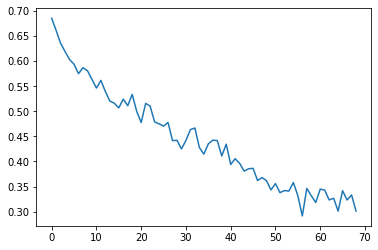

Epoch 1/100
22/22 - 10s - loss: 0.6862 - accuracy: 0.5362 - auc_43: 0.5693 - precision_43: 0.5225 - recall_43: 0.6295 - f1_score: 0.6581 - val_loss: 0.6926 - val_accuracy: 0.4667 - val_auc_43: 0.5491 - val_precision_43: 0.4583 - val_recall_43: 0.9706 - val_f1_score: 0.6239 - 10s/epoch - 468ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6661 - accuracy: 0.5953 - auc_43: 0.6437 - precision_43: 0.6051 - recall_43: 0.5030 - f1_score: 0.6581 - val_loss: 0.6911 - val_accuracy: 0.4667 - val_auc_43: 0.5169 - val_precision_43: 0.4000 - val_recall_43: 0.3529 - val_f1_score: 0.6239 - 3s/epoch - 116ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6378 - accuracy: 0.6455 - auc_43: 0.6883 - precision_43: 0.6456 - recall_43: 0.6145 - f1_score: 0.6581 - val_loss: 0.6908 - val_accuracy: 0.5467 - val_auc_43: 0.4157 - val_precision_43: 0.5000 - val_recall_43: 0.0588 - val_f1_score: 0.6239 - 3s/epoch - 116ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6280 - accuracy: 0.6499 - auc_43: 0.7022 - precision_43: 0.6621 - recall_4

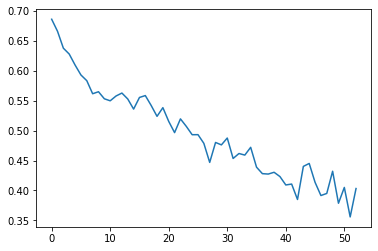

Epoch 1/100
22/22 - 10s - loss: 0.6851 - accuracy: 0.5451 - auc_44: 0.5728 - precision_44: 0.5676 - recall_44: 0.1950 - f1_score: 0.6460 - val_loss: 0.6752 - val_accuracy: 0.5867 - val_auc_44: 0.6602 - val_precision_44: 0.5811 - val_recall_44: 1.0000 - val_f1_score: 0.7288 - 10s/epoch - 455ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6547 - accuracy: 0.6086 - auc_44: 0.6573 - precision_44: 0.5873 - recall_44: 0.6037 - f1_score: 0.6460 - val_loss: 0.6721 - val_accuracy: 0.6267 - val_auc_44: 0.6850 - val_precision_44: 0.7027 - val_recall_44: 0.6047 - val_f1_score: 0.7288 - 3s/epoch - 119ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6473 - accuracy: 0.6174 - auc_44: 0.6659 - precision_44: 0.6103 - recall_44: 0.5480 - f1_score: 0.6460 - val_loss: 0.6688 - val_accuracy: 0.6000 - val_auc_44: 0.6962 - val_precision_44: 0.6383 - val_recall_44: 0.6977 - val_f1_score: 0.7288 - 3s/epoch - 118ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6338 - accuracy: 0.6470 - auc_44: 0.6925 - precision_44: 0.6338 - recall_4

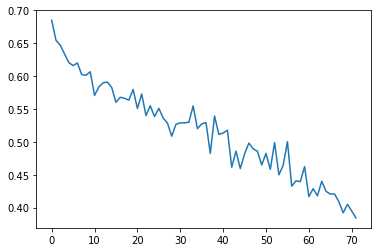

Epoch 1/100
22/22 - 10s - loss: 0.6816 - accuracy: 0.5761 - auc_45: 0.5965 - precision_45: 0.6289 - recall_45: 0.3049 - f1_score: 0.6527 - val_loss: 0.6882 - val_accuracy: 0.4800 - val_auc_45: 0.6732 - val_precision_45: 0.4932 - val_recall_45: 0.9474 - val_f1_score: 0.6726 - 10s/epoch - 440ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6494 - accuracy: 0.6337 - auc_45: 0.6782 - precision_45: 0.6481 - recall_45: 0.5335 - f1_score: 0.6527 - val_loss: 0.6805 - val_accuracy: 0.5067 - val_auc_45: 0.7219 - val_precision_45: 0.5067 - val_recall_45: 1.0000 - val_f1_score: 0.6726 - 3s/epoch - 116ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6248 - accuracy: 0.6440 - auc_45: 0.7140 - precision_45: 0.6232 - recall_45: 0.6707 - f1_score: 0.6527 - val_loss: 0.7012 - val_accuracy: 0.5467 - val_auc_45: 0.4619 - val_precision_45: 0.6111 - val_recall_45: 0.2895 - val_f1_score: 0.6726 - 3s/epoch - 116ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6081 - accuracy: 0.6706 - auc_45: 0.7296 - precision_45: 0.6646 - recall_4

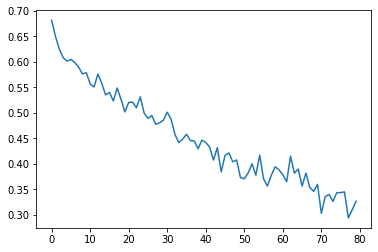

Epoch 1/100
22/22 - 10s - loss: 0.6892 - accuracy: 0.5332 - auc_46: 0.5399 - precision_46: 0.5497 - recall_46: 0.2823 - f1_score: 0.6594 - val_loss: 0.6906 - val_accuracy: 0.5600 - val_auc_46: 0.6674 - val_precision_46: 0.5000 - val_recall_46: 0.8182 - val_f1_score: 0.6111 - 10s/epoch - 444ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6695 - accuracy: 0.5953 - auc_46: 0.6316 - precision_46: 0.6311 - recall_46: 0.4264 - f1_score: 0.6594 - val_loss: 0.6874 - val_accuracy: 0.5467 - val_auc_46: 0.6003 - val_precision_46: 0.4857 - val_recall_46: 0.5152 - val_f1_score: 0.6111 - 3s/epoch - 116ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6653 - accuracy: 0.5820 - auc_46: 0.6292 - precision_46: 0.5812 - recall_46: 0.5375 - f1_score: 0.6594 - val_loss: 0.6819 - val_accuracy: 0.6000 - val_auc_46: 0.6043 - val_precision_46: 0.5652 - val_recall_46: 0.3939 - val_f1_score: 0.6111 - 3s/epoch - 116ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6537 - accuracy: 0.6219 - auc_46: 0.6588 - precision_46: 0.6332 - recall_4

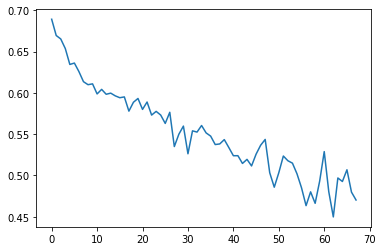

Epoch 1/100
22/22 - 10s - loss: 0.6865 - accuracy: 0.5554 - auc_47: 0.5697 - precision_47: 0.5481 - recall_47: 0.4526 - f1_score: 0.6514 - val_loss: 0.6958 - val_accuracy: 0.4667 - val_auc_47: 0.4049 - val_precision_47: 0.4000 - val_recall_47: 0.0513 - val_f1_score: 0.6842 - 10s/epoch - 446ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6543 - accuracy: 0.6145 - auc_47: 0.6647 - precision_47: 0.6196 - recall_47: 0.5229 - f1_score: 0.6514 - val_loss: 0.6927 - val_accuracy: 0.5333 - val_auc_47: 0.5242 - val_precision_47: 0.5294 - val_recall_47: 0.9231 - val_f1_score: 0.6842 - 3s/epoch - 117ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6346 - accuracy: 0.6750 - auc_47: 0.6871 - precision_47: 0.6801 - recall_47: 0.6177 - f1_score: 0.6514 - val_loss: 0.6916 - val_accuracy: 0.4933 - val_auc_47: 0.5680 - val_precision_47: 0.5072 - val_recall_47: 0.8974 - val_f1_score: 0.6842 - 3s/epoch - 115ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6248 - accuracy: 0.6499 - auc_47: 0.6955 - precision_47: 0.6607 - recall_4

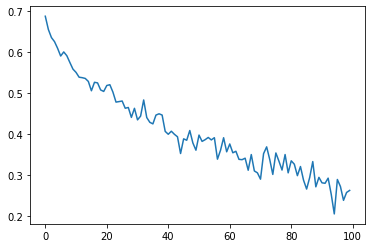

Epoch 1/100
22/22 - 9s - loss: 0.6911 - accuracy: 0.5362 - auc_48: 0.5418 - precision_48: 0.5398 - recall_48: 0.2896 - f1_score: 0.6527 - val_loss: 0.6907 - val_accuracy: 0.4267 - val_auc_48: 0.4758 - val_precision_48: 0.4138 - val_recall_48: 0.3158 - val_f1_score: 0.6726 - 9s/epoch - 425ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6759 - accuracy: 0.5746 - auc_48: 0.6046 - precision_48: 0.5730 - recall_48: 0.4787 - f1_score: 0.6527 - val_loss: 0.6802 - val_accuracy: 0.6267 - val_auc_48: 0.7166 - val_precision_48: 0.5781 - val_recall_48: 0.9737 - val_f1_score: 0.6726 - 3s/epoch - 116ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6584 - accuracy: 0.6248 - auc_48: 0.6536 - precision_48: 0.6457 - recall_48: 0.5000 - f1_score: 0.6527 - val_loss: 0.6794 - val_accuracy: 0.5067 - val_auc_48: 0.6824 - val_precision_48: 0.5067 - val_recall_48: 1.0000 - val_f1_score: 0.6726 - 3s/epoch - 115ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6573 - accuracy: 0.6071 - auc_48: 0.6573 - precision_48: 0.5833 - recall_48:

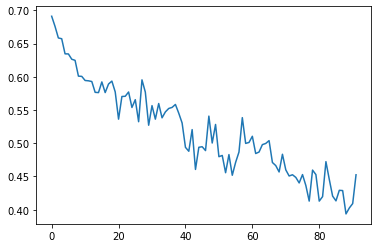

Epoch 1/100
22/22 - 10s - loss: 0.6875 - accuracy: 0.5362 - auc_49: 0.5454 - precision_49: 0.5296 - recall_49: 0.4073 - f1_score: 0.6541 - val_loss: 0.6941 - val_accuracy: 0.5067 - val_auc_49: 0.5331 - val_precision_49: 0.5000 - val_recall_49: 0.9189 - val_f1_score: 0.6607 - 10s/epoch - 454ms/step
Epoch 2/100
22/22 - 3s - loss: 0.6708 - accuracy: 0.6056 - auc_49: 0.6264 - precision_49: 0.6202 - recall_49: 0.4863 - f1_score: 0.6541 - val_loss: 0.6936 - val_accuracy: 0.5067 - val_auc_49: 0.5455 - val_precision_49: 0.5000 - val_recall_49: 0.0811 - val_f1_score: 0.6607 - 3s/epoch - 115ms/step
Epoch 3/100
22/22 - 3s - loss: 0.6509 - accuracy: 0.6455 - auc_49: 0.6627 - precision_49: 0.6450 - recall_49: 0.6018 - f1_score: 0.6541 - val_loss: 0.6991 - val_accuracy: 0.4533 - val_auc_49: 0.4296 - val_precision_49: 0.4643 - val_recall_49: 0.7027 - val_f1_score: 0.6607 - 3s/epoch - 114ms/step
Epoch 4/100
22/22 - 3s - loss: 0.6306 - accuracy: 0.6425 - auc_49: 0.7016 - precision_49: 0.6445 - recall_4

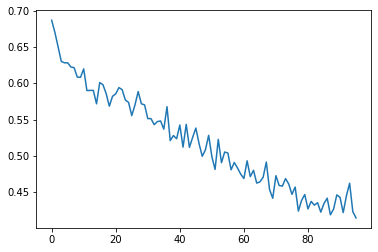

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_earlyfusion_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_earlyfusion_model.save(model_path / 'early_binary_cnnlstm.h5')

#### Training performance

In [ ]:
early_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_cnnlstm_train_results

{'Accuracy': 0.8318576097488404,
 'ROC/AUC': 0.910314291715622,
 'Precision': 0.8424403488636016,
 'Recall': 0.8042527914047242,
 'F1-score': 0.6547216892242431}

In [ ]:
early_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
early_cnnlstm_train_var

{'Accuracy': 0.0013717841640334427,
 'ROC/AUC': 0.0010758025322298082,
 'Precision': 0.0008943990775776812,
 'Recall': 0.0032951001362063435,
 'F1-score': 2.5144348339125602e-05}

#### Validation performance

In [ ]:
early_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_cnnlstm_val_results

{'Accuracy': 0.6181228071451187,
 'ROC/AUC': 0.647583681344986,
 'Precision': 0.6308673560619354,
 'Recall': 0.5301512181758881,
 'F1-score': 0.6531813502311706}

In [ ]:
early_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
early_cnnlstm_val_var

{'Accuracy': 0.006373752968976386,
 'ROC/AUC': 0.007516629861791593,
 'Precision': 0.012476851685378031,
 'Recall': 0.011660287262245817,
 'F1-score': 0.002107843036809385}

#### Predictions and performance on test set

In [ ]:
cnnlstm_binary_earlyfusion_model = load_model(model_path / 'early_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_earlyfusion_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 2s 31ms/step - loss: 1.6001 - accuracy: 0.3097 - auc_40: 0.4899 - precision_40: 0.8710 - recall_40: 0.2338 - f1_score: 0.9259
Accuracy: 30.97% 
ROC/AUC: 0.49 
Precision: 0.87 
Recall: 0.23 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

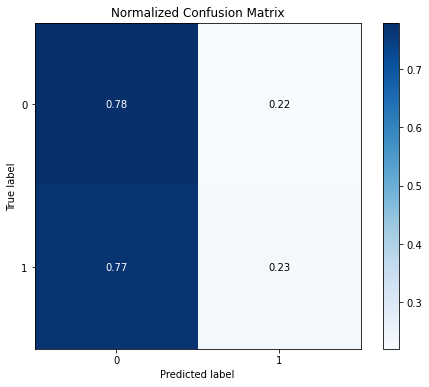

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

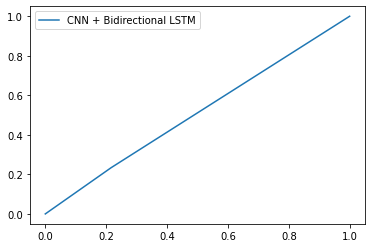

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

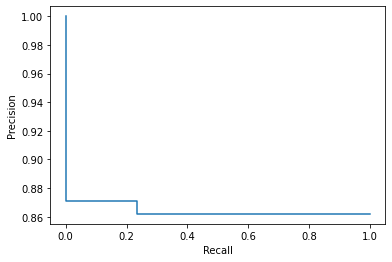

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 3.2 RCNN

Epoch 1/100
22/22 - 3s - loss: 0.8284 - accuracy: 0.5104 - auc_50: 0.5313 - precision_50: 0.4938 - recall_50: 0.6135 - f1_score: 0.6507 - val_loss: 0.6897 - val_accuracy: 0.5000 - val_auc_50: 0.4677 - val_precision_50: 0.5135 - val_recall_50: 0.9500 - val_f1_score: 0.6897 - 3s/epoch - 126ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7142 - accuracy: 0.5429 - auc_50: 0.5688 - precision_50: 0.5326 - recall_50: 0.4264 - f1_score: 0.6507 - val_loss: 0.6620 - val_accuracy: 0.5263 - val_auc_50: 0.5250 - val_precision_50: 0.5263 - val_recall_50: 1.0000 - val_f1_score: 0.6897 - 526ms/epoch - 24ms/step
Epoch 3/100
22/22 - 1s - loss: 0.8215 - accuracy: 0.5311 - auc_50: 0.5379 - precision_50: 0.5137 - recall_50: 0.5184 - f1_score: 0.6507 - val_loss: 0.6668 - val_accuracy: 0.5263 - val_auc_50: 0.5875 - val_precision_50: 0.5263 - val_recall_50: 1.0000 - val_f1_score: 0.6897 - 522ms/epoch - 24ms/step
Epoch 4/100
22/22 - 1s - loss: 0.8150 - accuracy: 0.5325 - auc_50: 0.5582 - precision_50: 0.5157 - recall

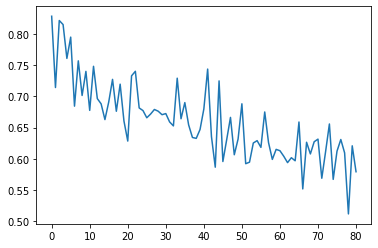

Epoch 1/100
22/22 - 3s - loss: 0.8089 - accuracy: 0.5178 - auc_51: 0.5252 - precision_51: 0.5093 - recall_51: 0.4139 - f1_score: 0.6574 - val_loss: 0.6748 - val_accuracy: 0.5395 - val_auc_51: 0.5237 - val_precision_51: 0.0000e+00 - val_recall_51: 0.0000e+00 - val_f1_score: 0.6306 - 3s/epoch - 126ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7968 - accuracy: 0.5444 - auc_51: 0.5655 - precision_51: 0.5441 - recall_51: 0.4290 - f1_score: 0.6574 - val_loss: 0.6821 - val_accuracy: 0.5395 - val_auc_51: 0.5244 - val_precision_51: 0.0000e+00 - val_recall_51: 0.0000e+00 - val_f1_score: 0.6306 - 532ms/epoch - 24ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7780 - accuracy: 0.5281 - auc_51: 0.5582 - precision_51: 0.5380 - recall_51: 0.2568 - f1_score: 0.6574 - val_loss: 0.6962 - val_accuracy: 0.5263 - val_auc_51: 0.5000 - val_precision_51: 0.0000e+00 - val_recall_51: 0.0000e+00 - val_f1_score: 0.6306 - 525ms/epoch - 24ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7675 - accuracy: 0.5533 - auc_51: 0.5936 - preci

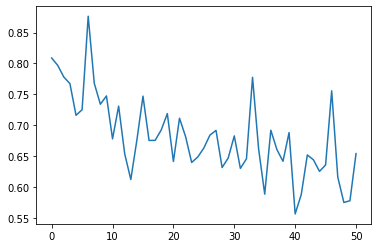

Epoch 1/100
22/22 - 3s - loss: 0.8331 - accuracy: 0.4993 - auc_52: 0.5121 - precision_52: 0.4966 - recall_52: 0.4362 - f1_score: 0.6647 - val_loss: 0.7149 - val_accuracy: 0.3867 - val_auc_52: 0.5000 - val_precision_52: 0.3867 - val_recall_52: 1.0000 - val_f1_score: 0.5577 - 3s/epoch - 127ms/step
Epoch 2/100
22/22 - 1s - loss: 0.8458 - accuracy: 0.5318 - auc_52: 0.5498 - precision_52: 0.5307 - recall_52: 0.5134 - f1_score: 0.6647 - val_loss: 0.6906 - val_accuracy: 0.6133 - val_auc_52: 0.5000 - val_precision_52: 0.0000e+00 - val_recall_52: 0.0000e+00 - val_f1_score: 0.5577 - 537ms/epoch - 24ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7321 - accuracy: 0.5451 - auc_52: 0.5730 - precision_52: 0.5650 - recall_52: 0.3739 - f1_score: 0.6647 - val_loss: 0.6755 - val_accuracy: 0.6133 - val_auc_52: 0.5000 - val_precision_52: 0.0000e+00 - val_recall_52: 0.0000e+00 - val_f1_score: 0.5577 - 529ms/epoch - 24ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7646 - accuracy: 0.5569 - auc_52: 0.5718 - precision_52:

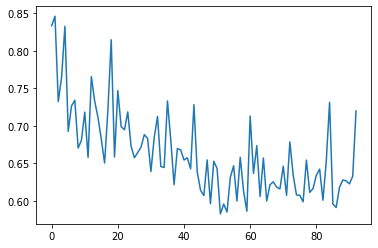

Epoch 1/100
22/22 - 3s - loss: 0.8221 - accuracy: 0.5465 - auc_53: 0.5459 - precision_53: 0.5294 - recall_53: 0.6777 - f1_score: 0.6581 - val_loss: 0.9802 - val_accuracy: 0.4667 - val_auc_53: 0.6280 - val_precision_53: 0.4595 - val_recall_53: 1.0000 - val_f1_score: 0.6239 - 3s/epoch - 141ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7668 - accuracy: 0.5613 - auc_53: 0.6029 - precision_53: 0.5424 - recall_53: 0.6747 - f1_score: 0.6581 - val_loss: 0.7749 - val_accuracy: 0.4667 - val_auc_53: 0.5814 - val_precision_53: 0.4583 - val_recall_53: 0.9706 - val_f1_score: 0.6239 - 531ms/epoch - 24ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7447 - accuracy: 0.5554 - auc_53: 0.5803 - precision_53: 0.5533 - recall_53: 0.4849 - f1_score: 0.6581 - val_loss: 1.0226 - val_accuracy: 0.5467 - val_auc_53: 0.4943 - val_precision_53: 0.0000e+00 - val_recall_53: 0.0000e+00 - val_f1_score: 0.6239 - 514ms/epoch - 23ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7572 - accuracy: 0.5096 - auc_53: 0.5444 - precision_53: 0.5000 

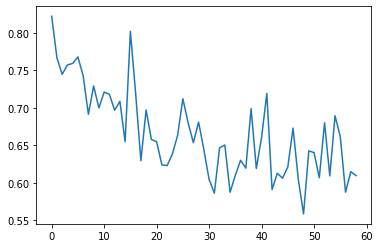

Epoch 1/100
22/22 - 3s - loss: 0.8259 - accuracy: 0.5303 - auc_54: 0.5401 - precision_54: 0.5108 - recall_54: 0.3653 - f1_score: 0.6460 - val_loss: 0.6854 - val_accuracy: 0.5600 - val_auc_54: 0.4967 - val_precision_54: 0.5676 - val_recall_54: 0.9767 - val_f1_score: 0.7288 - 3s/epoch - 125ms/step
Epoch 2/100
22/22 - 1s - loss: 0.8242 - accuracy: 0.5480 - auc_54: 0.5598 - precision_54: 0.5284 - recall_54: 0.4892 - f1_score: 0.6460 - val_loss: 1.3960 - val_accuracy: 0.4267 - val_auc_54: 0.5051 - val_precision_54: 0.0000e+00 - val_recall_54: 0.0000e+00 - val_f1_score: 0.7179 - 513ms/epoch - 23ms/step
Epoch 3/100
22/22 - 1s - loss: 0.8141 - accuracy: 0.5391 - auc_54: 0.5580 - precision_54: 0.5199 - recall_54: 0.4458 - f1_score: 0.6460 - val_loss: 0.8943 - val_accuracy: 0.4267 - val_auc_54: 0.4767 - val_precision_54: 0.0000e+00 - val_recall_54: 0.0000e+00 - val_f1_score: 0.7288 - 526ms/epoch - 24ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7233 - accuracy: 0.5864 - auc_54: 0.6202 - precision_54:

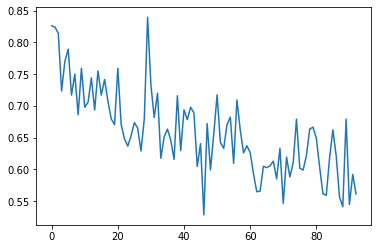

Epoch 1/100
22/22 - 3s - loss: 0.7758 - accuracy: 0.5303 - auc_55: 0.5358 - precision_55: 0.5180 - recall_55: 0.4390 - f1_score: 0.6527 - val_loss: 0.7904 - val_accuracy: 0.4933 - val_auc_55: 0.4719 - val_precision_55: 0.0000e+00 - val_recall_55: 0.0000e+00 - val_f1_score: 0.6726 - 3s/epoch - 129ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7665 - accuracy: 0.5258 - auc_55: 0.5517 - precision_55: 0.5169 - recall_55: 0.3262 - f1_score: 0.6527 - val_loss: 0.7104 - val_accuracy: 0.4933 - val_auc_55: 0.5000 - val_precision_55: 0.5000 - val_recall_55: 0.9737 - val_f1_score: 0.6726 - 560ms/epoch - 25ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7799 - accuracy: 0.5362 - auc_55: 0.5754 - precision_55: 0.5292 - recall_55: 0.3872 - f1_score: 0.6527 - val_loss: 1.3773 - val_accuracy: 0.4933 - val_auc_55: 0.4737 - val_precision_55: 0.0000e+00 - val_recall_55: 0.0000e+00 - val_f1_score: 0.6607 - 539ms/epoch - 25ms/step
Epoch 4/100
22/22 - 1s - loss: 0.8195 - accuracy: 0.5406 - auc_55: 0.5736 - precision_55:

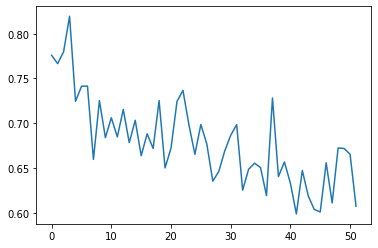

Epoch 1/100
22/22 - 3s - loss: 0.8075 - accuracy: 0.5037 - auc_56: 0.5306 - precision_56: 0.4955 - recall_56: 0.5015 - f1_score: 0.6594 - val_loss: 0.6933 - val_accuracy: 0.4667 - val_auc_56: 0.5000 - val_precision_56: 0.4444 - val_recall_56: 0.8485 - val_f1_score: 0.6111 - 3s/epoch - 132ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7566 - accuracy: 0.5436 - auc_56: 0.5600 - precision_56: 0.5326 - recall_56: 0.5886 - f1_score: 0.6594 - val_loss: 0.6886 - val_accuracy: 0.5600 - val_auc_56: 0.5000 - val_precision_56: 0.0000e+00 - val_recall_56: 0.0000e+00 - val_f1_score: 0.6111 - 588ms/epoch - 27ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7163 - accuracy: 0.5716 - auc_56: 0.5951 - precision_56: 0.5734 - recall_56: 0.5045 - f1_score: 0.6594 - val_loss: 0.6862 - val_accuracy: 0.5600 - val_auc_56: 0.5000 - val_precision_56: 0.0000e+00 - val_recall_56: 0.0000e+00 - val_f1_score: 0.6111 - 584ms/epoch - 27ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7193 - accuracy: 0.5805 - auc_56: 0.6269 - precision_56:

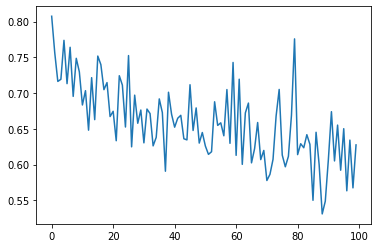

Epoch 1/100
22/22 - 3s - loss: 0.7897 - accuracy: 0.5303 - auc_57: 0.5592 - precision_57: 0.5124 - recall_57: 0.5688 - f1_score: 0.6514 - val_loss: 1.4107 - val_accuracy: 0.5200 - val_auc_57: 0.5388 - val_precision_57: 0.5200 - val_recall_57: 1.0000 - val_f1_score: 0.6842 - 3s/epoch - 153ms/step
Epoch 2/100
22/22 - 1s - loss: 0.8047 - accuracy: 0.5229 - auc_57: 0.5420 - precision_57: 0.5063 - recall_57: 0.4954 - f1_score: 0.6514 - val_loss: 1.1808 - val_accuracy: 0.5200 - val_auc_57: 0.5139 - val_precision_57: 0.5200 - val_recall_57: 1.0000 - val_f1_score: 0.6842 - 582ms/epoch - 26ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7648 - accuracy: 0.5598 - auc_57: 0.5938 - precision_57: 0.5539 - recall_57: 0.4557 - f1_score: 0.6514 - val_loss: 1.3398 - val_accuracy: 0.4933 - val_auc_57: 0.5370 - val_precision_57: 1.0000 - val_recall_57: 0.0256 - val_f1_score: 0.6842 - 568ms/epoch - 26ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7324 - accuracy: 0.5746 - auc_57: 0.6150 - precision_57: 0.5543 - recall

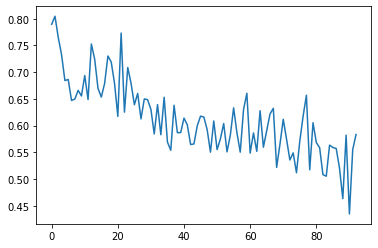

Epoch 1/100
22/22 - 3s - loss: 0.7878 - accuracy: 0.5229 - auc_58: 0.5361 - precision_58: 0.5088 - recall_58: 0.4421 - f1_score: 0.6527 - val_loss: 1.1610 - val_accuracy: 0.4933 - val_auc_58: 0.4730 - val_precision_58: 0.0000e+00 - val_recall_58: 0.0000e+00 - val_f1_score: 0.6726 - 3s/epoch - 132ms/step
Epoch 2/100
22/22 - 1s - loss: 0.8037 - accuracy: 0.5451 - auc_58: 0.5606 - precision_58: 0.5467 - recall_58: 0.3567 - f1_score: 0.6527 - val_loss: 0.8456 - val_accuracy: 0.5067 - val_auc_58: 0.6565 - val_precision_58: 0.5067 - val_recall_58: 1.0000 - val_f1_score: 0.6726 - 569ms/epoch - 26ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7194 - accuracy: 0.5657 - auc_58: 0.5927 - precision_58: 0.5616 - recall_58: 0.4726 - f1_score: 0.6527 - val_loss: 0.9261 - val_accuracy: 0.5067 - val_auc_58: 0.6398 - val_precision_58: 0.6667 - val_recall_58: 0.0526 - val_f1_score: 0.6726 - 563ms/epoch - 26ms/step
Epoch 4/100
22/22 - 1s - loss: 0.6995 - accuracy: 0.5820 - auc_58: 0.6378 - precision_58: 0.5652 

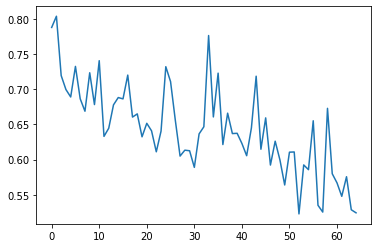

Epoch 1/100
22/22 - 3s - loss: 0.7967 - accuracy: 0.4934 - auc_59: 0.5255 - precision_59: 0.4768 - recall_59: 0.4377 - f1_score: 0.6541 - val_loss: 0.6867 - val_accuracy: 0.5067 - val_auc_59: 0.5395 - val_precision_59: 0.5000 - val_recall_59: 1.0000 - val_f1_score: 0.6607 - 3s/epoch - 132ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7663 - accuracy: 0.5451 - auc_59: 0.5878 - precision_59: 0.5237 - recall_59: 0.7052 - f1_score: 0.6541 - val_loss: 0.6916 - val_accuracy: 0.5067 - val_auc_59: 0.5263 - val_precision_59: 0.0000e+00 - val_recall_59: 0.0000e+00 - val_f1_score: 0.6607 - 574ms/epoch - 26ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7800 - accuracy: 0.5465 - auc_59: 0.5678 - precision_59: 0.5462 - recall_59: 0.3951 - f1_score: 0.6541 - val_loss: 0.6852 - val_accuracy: 0.5067 - val_auc_59: 0.5132 - val_precision_59: 0.0000e+00 - val_recall_59: 0.0000e+00 - val_f1_score: 0.6607 - 571ms/epoch - 26ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7118 - accuracy: 0.5894 - auc_59: 0.6207 - precision_59:

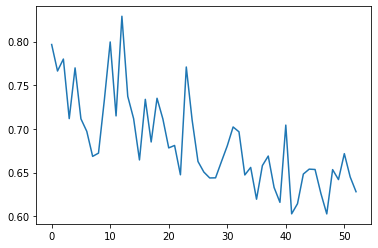

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_earlyfusion_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_earlyfusion_model.save(model_path / 'early_binary_rcnn.h5')

#### Training performance

In [ ]:
early_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_rcnn_train_results

{'Accuracy': 0.629133939743042,
 'ROC/AUC': 0.7094965279102325,
 'Precision': 0.6408905327320099,
 'Recall': 0.548692324757576,
 'F1-score': 0.6547216892242431}

In [ ]:
early_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
early_rcnn_train_var

{'Accuracy': 0.0014457416540913925,
 'ROC/AUC': 0.0020951561260817543,
 'Precision': 0.0015951887921307063,
 'Recall': 0.010075276851919676,
 'F1-score': 2.5144348339125602e-05}

#### Validation performance

In [ ]:
early_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_rcnn_val_results

{'Accuracy': 0.4879824578762054,
 'ROC/AUC': 0.5295276373624802,
 'Precision': 0.5707214623689651,
 'Recall': 0.4246904311701655,
 'F1-score': 0.6531813502311706}

In [ ]:
early_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
early_rcnn_val_var

{'Accuracy': 0.0026443663743851075,
 'ROC/AUC': 0.0015446182792403194,
 'Precision': 0.08446736468574963,
 'Recall': 0.2164879157793964,
 'F1-score': 0.002107843036809385}

#### Predictions and performance on test set

In [ ]:
rcnn_binary_earlyfusion_model = load_model(model_path / 'early_binary_rcnn.h5')
y_pred = rcnn_binary_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_earlyfusion_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 10ms/step - loss: 0.7562 - accuracy: 0.1493 - auc_57: 0.6361 - precision_57: 0.7143 - recall_57: 0.0216 - f1_score: 0.9259
Accuracy: 14.93% 
ROC/AUC: 0.64 
Precision: 0.71 
Recall: 0.02 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

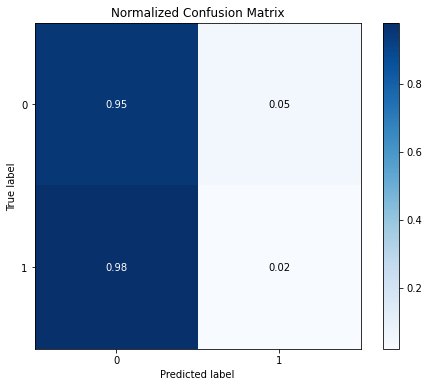

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

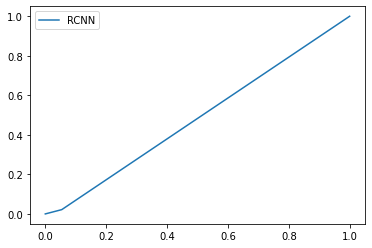

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

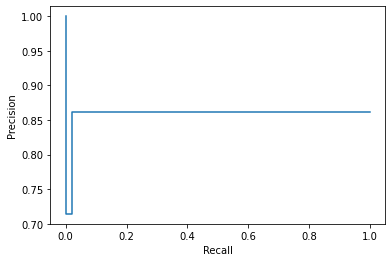

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## 4. Multimodal Late Fusion

In [ ]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', binary=True, fusion=True)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(752, 1, 350, 35) (752, 1)
(268, 1, 350, 35) (268, 1)


In [ ]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', binary=True)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(752, 1, 350, 25) (752, 1)
(268, 1, 350, 25) (268, 1)


In [ ]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### 4.1 CNN + BiLSTM (Concatenation)

Epoch 1/100
22/22 - 18s - loss: 0.6850 - accuracy: 0.5399 - auc_60: 0.5756 - precision_60: 0.5271 - recall_60: 0.4479 - f1_score: 0.6507 - val_loss: 0.6988 - val_accuracy: 0.5000 - val_auc_60: 0.5778 - val_precision_60: 1.0000 - val_recall_60: 0.0500 - val_f1_score: 0.6897 - 18s/epoch - 815ms/step
Epoch 2/100
22/22 - 5s - loss: 0.6349 - accuracy: 0.6479 - auc_60: 0.6961 - precision_60: 0.6517 - recall_60: 0.5798 - f1_score: 0.6507 - val_loss: 0.6835 - val_accuracy: 0.5789 - val_auc_60: 0.6003 - val_precision_60: 0.6111 - val_recall_60: 0.5500 - val_f1_score: 0.6897 - 5s/epoch - 227ms/step
Epoch 3/100
22/22 - 5s - loss: 0.6027 - accuracy: 0.6775 - auc_60: 0.7396 - precision_60: 0.6742 - recall_60: 0.6411 - f1_score: 0.6507 - val_loss: 0.6709 - val_accuracy: 0.5263 - val_auc_60: 0.7212 - val_precision_60: 0.5263 - val_recall_60: 1.0000 - val_f1_score: 0.6897 - 5s/epoch - 228ms/step
Epoch 4/100
22/22 - 5s - loss: 0.5681 - accuracy: 0.7293 - auc_60: 0.7878 - precision_60: 0.7134 - recall_6

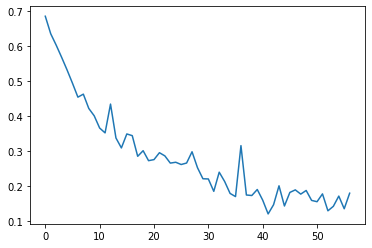

Epoch 1/100
22/22 - 18s - loss: 0.6721 - accuracy: 0.6095 - auc_61: 0.6355 - precision_61: 0.6044 - recall_61: 0.5861 - f1_score: 0.6574 - val_loss: 0.7022 - val_accuracy: 0.4605 - val_auc_61: 0.6655 - val_precision_61: 0.4605 - val_recall_61: 1.0000 - val_f1_score: 0.6306 - 18s/epoch - 822ms/step
Epoch 2/100
22/22 - 5s - loss: 0.6231 - accuracy: 0.6627 - auc_61: 0.7161 - precision_61: 0.6746 - recall_61: 0.6012 - f1_score: 0.6574 - val_loss: 0.9116 - val_accuracy: 0.4605 - val_auc_61: 0.5892 - val_precision_61: 0.4605 - val_recall_61: 1.0000 - val_f1_score: 0.6306 - 5s/epoch - 232ms/step
Epoch 3/100
22/22 - 5s - loss: 0.5782 - accuracy: 0.7249 - auc_61: 0.7680 - precision_61: 0.7231 - recall_61: 0.7100 - f1_score: 0.6574 - val_loss: 0.6977 - val_accuracy: 0.5921 - val_auc_61: 0.5676 - val_precision_61: 0.5345 - val_recall_61: 0.8857 - val_f1_score: 0.6306 - 5s/epoch - 233ms/step
Epoch 4/100
22/22 - 5s - loss: 0.5466 - accuracy: 0.7456 - auc_61: 0.7987 - precision_61: 0.7540 - recall_6

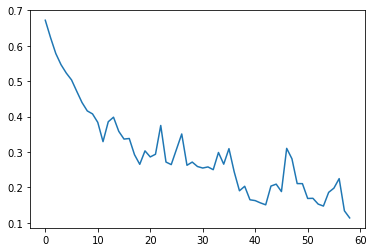

Epoch 1/100
22/22 - 18s - loss: 0.6779 - accuracy: 0.5731 - auc_62: 0.6025 - precision_62: 0.5822 - recall_62: 0.5045 - f1_score: 0.6647 - val_loss: 0.6848 - val_accuracy: 0.6133 - val_auc_62: 0.4561 - val_precision_62: 0.5000 - val_recall_62: 0.0345 - val_f1_score: 0.5577 - 18s/epoch - 829ms/step
Epoch 2/100
22/22 - 5s - loss: 0.6277 - accuracy: 0.6499 - auc_62: 0.7061 - precision_62: 0.6634 - recall_62: 0.6024 - f1_score: 0.6647 - val_loss: 0.7037 - val_accuracy: 0.5067 - val_auc_62: 0.5172 - val_precision_62: 0.4130 - val_recall_62: 0.6552 - val_f1_score: 0.5577 - 5s/epoch - 226ms/step
Epoch 3/100
22/22 - 5s - loss: 0.5857 - accuracy: 0.6928 - auc_62: 0.7573 - precision_62: 0.7061 - recall_62: 0.6558 - f1_score: 0.6647 - val_loss: 0.7599 - val_accuracy: 0.4267 - val_auc_62: 0.5480 - val_precision_62: 0.4028 - val_recall_62: 1.0000 - val_f1_score: 0.5577 - 5s/epoch - 226ms/step
Epoch 4/100
22/22 - 5s - loss: 0.5619 - accuracy: 0.7194 - auc_62: 0.7855 - precision_62: 0.7333 - recall_6

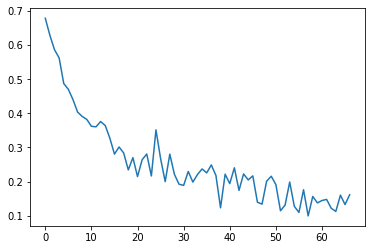

Epoch 1/100
22/22 - 18s - loss: 0.6797 - accuracy: 0.5805 - auc_63: 0.6068 - precision_63: 0.5741 - recall_63: 0.5602 - f1_score: 0.6581 - val_loss: 0.7108 - val_accuracy: 0.4533 - val_auc_63: 0.5086 - val_precision_63: 0.4533 - val_recall_63: 1.0000 - val_f1_score: 0.6239 - 18s/epoch - 830ms/step
Epoch 2/100
22/22 - 5s - loss: 0.6242 - accuracy: 0.6647 - auc_63: 0.7136 - precision_63: 0.6710 - recall_63: 0.6205 - f1_score: 0.6581 - val_loss: 0.8199 - val_accuracy: 0.4533 - val_auc_63: 0.5778 - val_precision_63: 0.4533 - val_recall_63: 1.0000 - val_f1_score: 0.6239 - 5s/epoch - 228ms/step
Epoch 3/100
22/22 - 5s - loss: 0.6017 - accuracy: 0.6795 - auc_63: 0.7412 - precision_63: 0.6620 - recall_63: 0.7078 - f1_score: 0.6581 - val_loss: 0.7724 - val_accuracy: 0.4533 - val_auc_63: 0.6410 - val_precision_63: 0.4533 - val_recall_63: 1.0000 - val_f1_score: 0.6239 - 5s/epoch - 228ms/step
Epoch 4/100
22/22 - 5s - loss: 0.5464 - accuracy: 0.7253 - auc_63: 0.7993 - precision_63: 0.7325 - recall_6

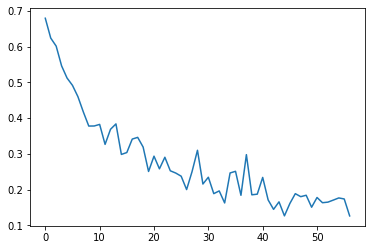

Epoch 1/100
22/22 - 17s - loss: 0.6802 - accuracy: 0.5820 - auc_64: 0.5891 - precision_64: 0.6163 - recall_64: 0.3282 - f1_score: 0.6460 - val_loss: 0.6898 - val_accuracy: 0.5200 - val_auc_64: 0.5294 - val_precision_64: 0.6400 - val_recall_64: 0.3721 - val_f1_score: 0.7288 - 17s/epoch - 782ms/step
Epoch 2/100
22/22 - 5s - loss: 0.6391 - accuracy: 0.6322 - auc_64: 0.6863 - precision_64: 0.6233 - recall_64: 0.5789 - f1_score: 0.6460 - val_loss: 0.6786 - val_accuracy: 0.5600 - val_auc_64: 0.5825 - val_precision_64: 0.5676 - val_recall_64: 0.9767 - val_f1_score: 0.7288 - 5s/epoch - 207ms/step
Epoch 3/100
22/22 - 4s - loss: 0.5982 - accuracy: 0.6780 - auc_64: 0.7463 - precision_64: 0.6744 - recall_64: 0.6285 - f1_score: 0.6460 - val_loss: 0.6844 - val_accuracy: 0.5733 - val_auc_64: 0.6250 - val_precision_64: 0.5733 - val_recall_64: 1.0000 - val_f1_score: 0.7288 - 4s/epoch - 203ms/step
Epoch 4/100
22/22 - 4s - loss: 0.5643 - accuracy: 0.7120 - auc_64: 0.7823 - precision_64: 0.6988 - recall_6

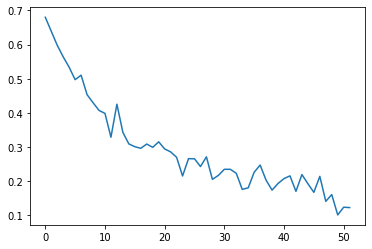

Epoch 1/100
22/22 - 17s - loss: 0.6731 - accuracy: 0.5968 - auc_65: 0.6295 - precision_65: 0.6180 - recall_65: 0.4390 - f1_score: 0.6527 - val_loss: 0.6860 - val_accuracy: 0.5067 - val_auc_65: 0.6252 - val_precision_65: 0.5067 - val_recall_65: 1.0000 - val_f1_score: 0.6726 - 17s/epoch - 780ms/step
Epoch 2/100
22/22 - 5s - loss: 0.6363 - accuracy: 0.6603 - auc_65: 0.6941 - precision_65: 0.6561 - recall_65: 0.6280 - f1_score: 0.6527 - val_loss: 0.6771 - val_accuracy: 0.5600 - val_auc_65: 0.6451 - val_precision_65: 0.5410 - val_recall_65: 0.8684 - val_f1_score: 0.6726 - 5s/epoch - 207ms/step
Epoch 3/100
22/22 - 4s - loss: 0.5807 - accuracy: 0.7090 - auc_65: 0.7663 - precision_65: 0.7120 - recall_65: 0.6707 - f1_score: 0.6527 - val_loss: 0.6799 - val_accuracy: 0.5333 - val_auc_65: 0.6042 - val_precision_65: 0.5246 - val_recall_65: 0.8421 - val_f1_score: 0.6726 - 4s/epoch - 203ms/step
Epoch 4/100
22/22 - 5s - loss: 0.5589 - accuracy: 0.7238 - auc_65: 0.7887 - precision_65: 0.7196 - recall_6

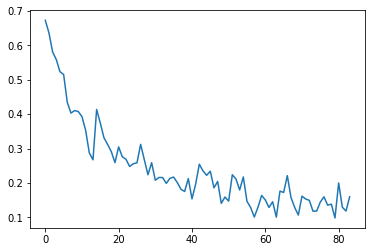

Epoch 1/100
22/22 - 17s - loss: 0.6881 - accuracy: 0.5391 - auc_66: 0.5514 - precision_66: 0.5418 - recall_66: 0.4084 - f1_score: 0.6594 - val_loss: 0.6917 - val_accuracy: 0.5333 - val_auc_66: 0.5090 - val_precision_66: 0.4643 - val_recall_66: 0.3939 - val_f1_score: 0.6111 - 17s/epoch - 780ms/step
Epoch 2/100
22/22 - 5s - loss: 0.6264 - accuracy: 0.6721 - auc_66: 0.7176 - precision_66: 0.6975 - recall_66: 0.5886 - f1_score: 0.6594 - val_loss: 0.8192 - val_accuracy: 0.4400 - val_auc_66: 0.6014 - val_precision_66: 0.4400 - val_recall_66: 1.0000 - val_f1_score: 0.6111 - 5s/epoch - 205ms/step
Epoch 3/100
22/22 - 5s - loss: 0.6105 - accuracy: 0.6691 - auc_66: 0.7286 - precision_66: 0.6617 - recall_66: 0.6697 - f1_score: 0.6594 - val_loss: 0.6901 - val_accuracy: 0.5733 - val_auc_66: 0.4654 - val_precision_66: 0.6667 - val_recall_66: 0.0606 - val_f1_score: 0.6111 - 5s/epoch - 205ms/step
Epoch 4/100
22/22 - 4s - loss: 0.5785 - accuracy: 0.6942 - auc_66: 0.7669 - precision_66: 0.7100 - recall_6

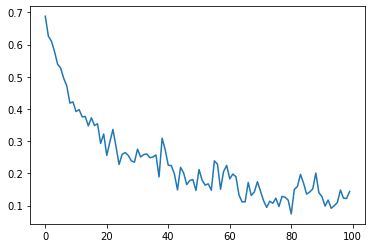

Epoch 1/100
22/22 - 21s - loss: 0.6748 - accuracy: 0.5613 - auc_67: 0.6077 - precision_67: 0.5605 - recall_67: 0.4251 - f1_score: 0.6514 - val_loss: 0.7027 - val_accuracy: 0.4933 - val_auc_67: 0.5922 - val_precision_67: 0.6000 - val_recall_67: 0.0769 - val_f1_score: 0.6842 - 21s/epoch - 948ms/step
Epoch 2/100
22/22 - 6s - loss: 0.6302 - accuracy: 0.6736 - auc_67: 0.7065 - precision_67: 0.6840 - recall_67: 0.6024 - f1_score: 0.6514 - val_loss: 0.7111 - val_accuracy: 0.5200 - val_auc_67: 0.6026 - val_precision_67: 0.5200 - val_recall_67: 1.0000 - val_f1_score: 0.6842 - 6s/epoch - 252ms/step
Epoch 3/100
22/22 - 5s - loss: 0.5901 - accuracy: 0.6987 - auc_67: 0.7550 - precision_67: 0.6814 - recall_67: 0.7064 - f1_score: 0.6514 - val_loss: 0.6929 - val_accuracy: 0.5067 - val_auc_67: 0.5424 - val_precision_67: 0.5167 - val_recall_67: 0.7949 - val_f1_score: 0.6842 - 5s/epoch - 249ms/step
Epoch 4/100
22/22 - 6s - loss: 0.5557 - accuracy: 0.7208 - auc_67: 0.7881 - precision_67: 0.7091 - recall_6

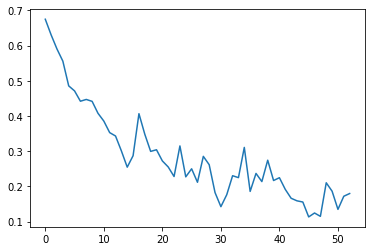

Epoch 1/100
22/22 - 18s - loss: 0.6835 - accuracy: 0.5524 - auc_68: 0.5791 - precision_68: 0.5413 - recall_68: 0.5000 - f1_score: 0.6527 - val_loss: 0.6970 - val_accuracy: 0.5067 - val_auc_68: 0.6718 - val_precision_68: 0.5067 - val_recall_68: 1.0000 - val_f1_score: 0.6726 - 18s/epoch - 811ms/step
Epoch 2/100
22/22 - 5s - loss: 0.6387 - accuracy: 0.6248 - auc_68: 0.6913 - precision_68: 0.6178 - recall_68: 0.5915 - f1_score: 0.6527 - val_loss: 0.7505 - val_accuracy: 0.5067 - val_auc_68: 0.7457 - val_precision_68: 0.5067 - val_recall_68: 1.0000 - val_f1_score: 0.6726 - 5s/epoch - 245ms/step
Epoch 3/100
22/22 - 6s - loss: 0.5923 - accuracy: 0.6883 - auc_68: 0.7539 - precision_68: 0.6944 - recall_68: 0.6372 - f1_score: 0.6527 - val_loss: 0.9319 - val_accuracy: 0.5067 - val_auc_68: 0.7617 - val_precision_68: 0.5067 - val_recall_68: 1.0000 - val_f1_score: 0.6726 - 6s/epoch - 256ms/step
Epoch 4/100
22/22 - 5s - loss: 0.5526 - accuracy: 0.7267 - auc_68: 0.7913 - precision_68: 0.7214 - recall_6

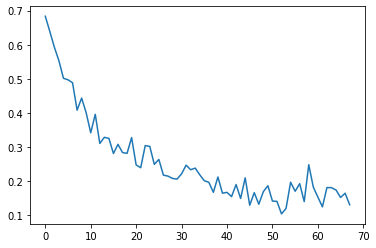

Epoch 1/100
22/22 - 18s - loss: 0.6806 - accuracy: 0.5805 - auc_69: 0.6124 - precision_69: 0.5714 - recall_69: 0.5471 - f1_score: 0.6541 - val_loss: 0.6931 - val_accuracy: 0.5067 - val_auc_69: 0.6824 - val_precision_69: 0.0000e+00 - val_recall_69: 0.0000e+00 - val_f1_score: 0.6607 - 18s/epoch - 833ms/step
Epoch 2/100
22/22 - 6s - loss: 0.6325 - accuracy: 0.6440 - auc_69: 0.6979 - precision_69: 0.6538 - recall_69: 0.5684 - f1_score: 0.6541 - val_loss: 0.7200 - val_accuracy: 0.4933 - val_auc_69: 0.6568 - val_precision_69: 0.4933 - val_recall_69: 1.0000 - val_f1_score: 0.6607 - 6s/epoch - 253ms/step
Epoch 3/100
22/22 - 6s - loss: 0.5965 - accuracy: 0.6824 - auc_69: 0.7490 - precision_69: 0.6939 - recall_69: 0.6201 - f1_score: 0.6541 - val_loss: 0.8582 - val_accuracy: 0.4933 - val_auc_69: 0.6430 - val_precision_69: 0.4933 - val_recall_69: 1.0000 - val_f1_score: 0.6607 - 6s/epoch - 255ms/step
Epoch 4/100
22/22 - 6s - loss: 0.5632 - accuracy: 0.7149 - auc_69: 0.7803 - precision_69: 0.7036 - 

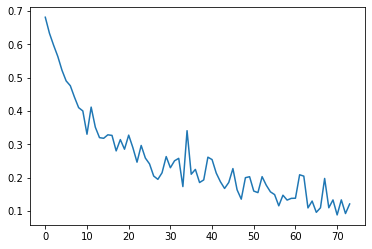

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_latefusion_model = CNNLSTM_fusioned(body_features, face_features, n_length, n_outputs)
    history = cnnlstm_binary_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_latefusion_model.save(model_path / 'late_binary_cnnlstm.h5')

#### Training performance

In [ ]:
late_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_cnnlstm_train_results

{'Accuracy': 0.947841590642929,
 'ROC/AUC': 0.9869986712932587,
 'Precision': 0.9437565565109253,
 'Recall': 0.9495983421802521,
 'F1-score': 0.6547216892242431}

In [ ]:
late_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
late_cnnlstm_train_var

{'Accuracy': 0.00013200179965725312,
 'ROC/AUC': 1.893465118630644e-05,
 'Precision': 0.00025874620683637774,
 'Recall': 0.0001950326303040484,
 'F1-score': 2.5144348339125602e-05}

#### Validation performance

In [ ]:
late_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_cnnlstm_val_results

{'Accuracy': 0.6236666709184646,
 'ROC/AUC': 0.6978638648986817,
 'Precision': 0.6112300127744674,
 'Recall': 0.6908635377883912,
 'F1-score': 0.6531813502311706}

In [ ]:
late_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
late_cnnlstm_val_var

{'Accuracy': 0.008237946945289289,
 'ROC/AUC': 0.00594831588169086,
 'Precision': 0.01373520203673565,
 'Recall': 0.0114820708816508,
 'F1-score': 0.002107843036809385}

#### Performance and predictions on test set

In [ ]:
cnnlstm_binary_latefusion_model = load_model(model_path / 'late_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = cnnlstm_binary_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
cnnlstm_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 3s 85ms/step - loss: 1.9468 - accuracy: 0.3619 - auc_66: 0.5493 - precision_66: 0.8571 - recall_66: 0.3117 - f1_score: 0.9259
Accuracy: 36.19% 
ROC/AUC: 0.55 
Precision: 0.86 
Recall: 0.31 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

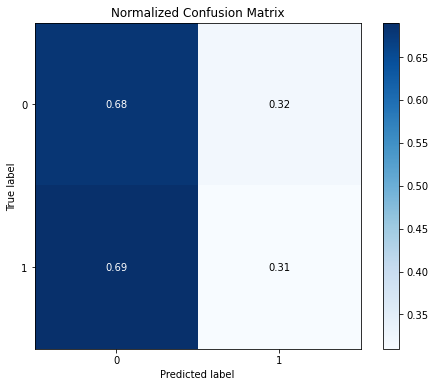

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

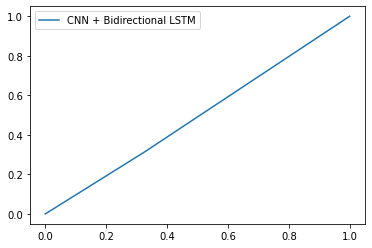

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

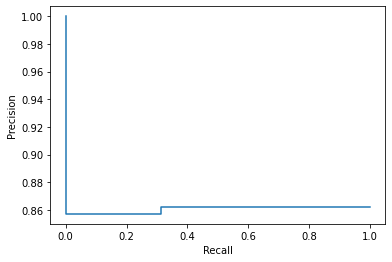

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 4.2 RCNN (Concatenation)

Epoch 1/100
22/22 - 5s - loss: 0.8634 - accuracy: 0.5695 - auc_70: 0.5911 - precision_70: 0.5559 - recall_70: 0.5337 - f1_score: 0.6507 - val_loss: 0.6883 - val_accuracy: 0.6184 - val_auc_70: 0.7115 - val_precision_70: 0.6000 - val_recall_70: 0.8250 - val_f1_score: 0.6897 - 5s/epoch - 231ms/step
Epoch 2/100
22/22 - 1s - loss: 0.8470 - accuracy: 0.6331 - auc_70: 0.6649 - precision_70: 0.6196 - recall_70: 0.6196 - f1_score: 0.6507 - val_loss: 2.6402 - val_accuracy: 0.4868 - val_auc_70: 0.6740 - val_precision_70: 1.0000 - val_recall_70: 0.0250 - val_f1_score: 0.6897 - 1s/epoch - 51ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7147 - accuracy: 0.6598 - auc_70: 0.7224 - precision_70: 0.6519 - recall_70: 0.6319 - f1_score: 0.6507 - val_loss: 0.9971 - val_accuracy: 0.6053 - val_auc_70: 0.7361 - val_precision_70: 0.5758 - val_recall_70: 0.9500 - val_f1_score: 0.6897 - 1s/epoch - 51ms/step
Epoch 4/100
22/22 - 1s - loss: 0.8106 - accuracy: 0.6686 - auc_70: 0.7071 - precision_70: 0.6545 - recall_70: 0

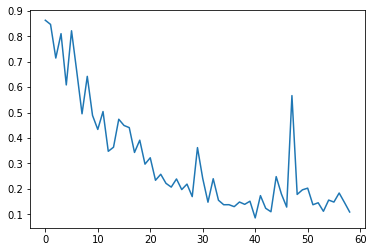

Epoch 1/100
22/22 - 5s - loss: 0.9269 - accuracy: 0.5888 - auc_71: 0.6020 - precision_71: 0.5852 - recall_71: 0.5498 - f1_score: 0.6574 - val_loss: 5.7513 - val_accuracy: 0.4605 - val_auc_71: 0.5244 - val_precision_71: 0.4605 - val_recall_71: 1.0000 - val_f1_score: 0.6306 - 5s/epoch - 221ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7809 - accuracy: 0.6331 - auc_71: 0.6869 - precision_71: 0.6239 - recall_71: 0.6314 - f1_score: 0.6574 - val_loss: 1.2725 - val_accuracy: 0.4737 - val_auc_71: 0.4293 - val_precision_71: 0.2222 - val_recall_71: 0.0571 - val_f1_score: 0.6306 - 1s/epoch - 51ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6722 - accuracy: 0.6864 - auc_71: 0.7443 - precision_71: 0.6913 - recall_71: 0.6495 - f1_score: 0.6574 - val_loss: 8.1683 - val_accuracy: 0.4605 - val_auc_71: 0.5244 - val_precision_71: 0.4605 - val_recall_71: 1.0000 - val_f1_score: 0.6306 - 1s/epoch - 51ms/step
Epoch 4/100
22/22 - 1s - loss: 0.9115 - accuracy: 0.6361 - auc_71: 0.6823 - precision_71: 0.6211 - recall_71: 0

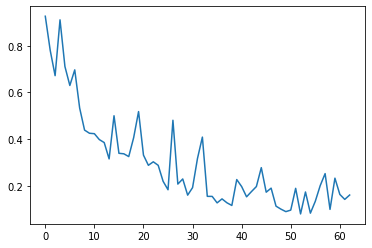

Epoch 1/100
22/22 - 6s - loss: 0.8394 - accuracy: 0.5731 - auc_72: 0.6173 - precision_72: 0.5732 - recall_72: 0.5579 - f1_score: 0.6647 - val_loss: 9.2784 - val_accuracy: 0.3867 - val_auc_72: 0.5000 - val_precision_72: 0.3867 - val_recall_72: 1.0000 - val_f1_score: 0.5577 - 6s/epoch - 255ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7234 - accuracy: 0.6440 - auc_72: 0.6949 - precision_72: 0.6463 - recall_72: 0.6291 - f1_score: 0.6647 - val_loss: 0.6911 - val_accuracy: 0.6533 - val_auc_72: 0.6503 - val_precision_72: 0.6000 - val_recall_72: 0.3103 - val_f1_score: 0.5577 - 1s/epoch - 51ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7330 - accuracy: 0.6455 - auc_72: 0.7128 - precision_72: 0.6502 - recall_72: 0.6231 - f1_score: 0.6647 - val_loss: 1.0119 - val_accuracy: 0.5200 - val_auc_72: 0.6747 - val_precision_72: 0.4444 - val_recall_72: 0.9655 - val_f1_score: 0.5577 - 1s/epoch - 51ms/step
Epoch 4/100
22/22 - 1s - loss: 0.6792 - accuracy: 0.7105 - auc_72: 0.7659 - precision_72: 0.7156 - recall_72: 0

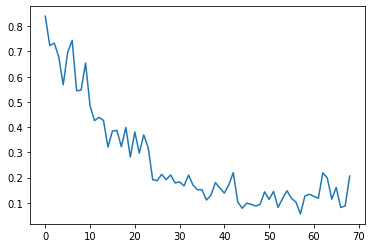

Epoch 1/100
22/22 - 5s - loss: 0.9121 - accuracy: 0.5657 - auc_73: 0.5882 - precision_73: 0.5594 - recall_73: 0.5392 - f1_score: 0.6581 - val_loss: 1.8077 - val_accuracy: 0.4533 - val_auc_73: 0.5359 - val_precision_73: 0.4507 - val_recall_73: 0.9412 - val_f1_score: 0.6239 - 5s/epoch - 218ms/step
Epoch 2/100
22/22 - 1s - loss: 0.8167 - accuracy: 0.6219 - auc_73: 0.6750 - precision_73: 0.6226 - recall_73: 0.5813 - f1_score: 0.6581 - val_loss: 7.4989 - val_accuracy: 0.4533 - val_auc_73: 0.5000 - val_precision_73: 0.4533 - val_recall_73: 1.0000 - val_f1_score: 0.6239 - 1s/epoch - 51ms/step
Epoch 3/100
22/22 - 1s - loss: 0.8172 - accuracy: 0.6691 - auc_73: 0.7049 - precision_73: 0.6677 - recall_73: 0.6476 - f1_score: 0.6581 - val_loss: 3.7367 - val_accuracy: 0.4533 - val_auc_73: 0.5043 - val_precision_73: 0.4533 - val_recall_73: 1.0000 - val_f1_score: 0.6239 - 1s/epoch - 50ms/step
Epoch 4/100
22/22 - 1s - loss: 0.6966 - accuracy: 0.6869 - auc_73: 0.7434 - precision_73: 0.6775 - recall_73: 0

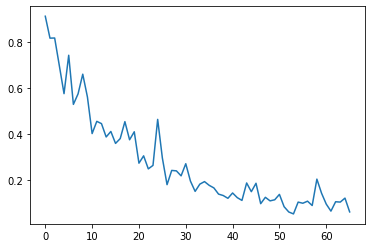

Epoch 1/100
22/22 - 5s - loss: 0.9333 - accuracy: 0.5702 - auc_74: 0.5841 - precision_74: 0.5491 - recall_74: 0.5542 - f1_score: 0.6460 - val_loss: 7.1654 - val_accuracy: 0.5733 - val_auc_74: 0.5000 - val_precision_74: 0.5733 - val_recall_74: 1.0000 - val_f1_score: 0.7288 - 5s/epoch - 218ms/step
Epoch 2/100
22/22 - 1s - loss: 0.8091 - accuracy: 0.6366 - auc_74: 0.6857 - precision_74: 0.6207 - recall_74: 0.6130 - f1_score: 0.6460 - val_loss: 3.3808 - val_accuracy: 0.4267 - val_auc_74: 0.6813 - val_precision_74: 0.0000e+00 - val_recall_74: 0.0000e+00 - val_f1_score: 0.7179 - 1s/epoch - 51ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7364 - accuracy: 0.6750 - auc_74: 0.7241 - precision_74: 0.6859 - recall_74: 0.5882 - f1_score: 0.6460 - val_loss: 2.3998 - val_accuracy: 0.5733 - val_auc_74: 0.6664 - val_precision_74: 0.5733 - val_recall_74: 1.0000 - val_f1_score: 0.7288 - 1s/epoch - 52ms/step
Epoch 4/100
22/22 - 1s - loss: 0.6382 - accuracy: 0.6928 - auc_74: 0.7716 - precision_74: 0.6837 - reca

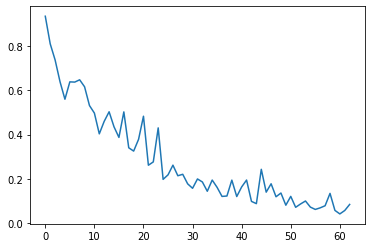

Epoch 1/100
22/22 - 5s - loss: 0.9100 - accuracy: 0.5790 - auc_75: 0.6166 - precision_75: 0.5657 - recall_75: 0.5640 - f1_score: 0.6527 - val_loss: 3.7199 - val_accuracy: 0.5067 - val_auc_75: 0.5149 - val_precision_75: 0.5067 - val_recall_75: 1.0000 - val_f1_score: 0.6726 - 5s/epoch - 217ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7602 - accuracy: 0.6233 - auc_75: 0.6811 - precision_75: 0.6130 - recall_75: 0.6037 - f1_score: 0.6527 - val_loss: 6.0538 - val_accuracy: 0.4933 - val_auc_75: 0.5132 - val_precision_75: 0.0000e+00 - val_recall_75: 0.0000e+00 - val_f1_score: 0.6726 - 1s/epoch - 50ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7058 - accuracy: 0.6809 - auc_75: 0.7373 - precision_75: 0.6892 - recall_75: 0.6220 - f1_score: 0.6534 - val_loss: 4.2988 - val_accuracy: 0.5067 - val_auc_75: 0.5277 - val_precision_75: 0.5067 - val_recall_75: 1.0000 - val_f1_score: 0.6726 - 1s/epoch - 50ms/step
Epoch 4/100
22/22 - 1s - loss: 0.8040 - accuracy: 0.6396 - auc_75: 0.6981 - precision_75: 0.6280 - reca

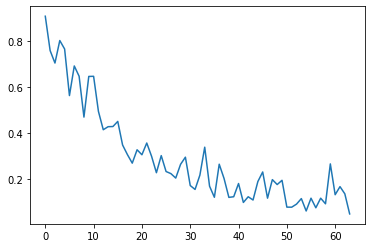

Epoch 1/100
22/22 - 5s - loss: 0.9228 - accuracy: 0.5657 - auc_76: 0.5819 - precision_76: 0.5600 - recall_76: 0.5465 - f1_score: 0.6594 - val_loss: 2.4095 - val_accuracy: 0.4400 - val_auc_76: 0.6273 - val_precision_76: 0.4400 - val_recall_76: 1.0000 - val_f1_score: 0.6111 - 5s/epoch - 246ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7464 - accuracy: 0.6484 - auc_76: 0.7015 - precision_76: 0.6568 - recall_76: 0.5976 - f1_score: 0.6594 - val_loss: 1.5829 - val_accuracy: 0.5467 - val_auc_76: 0.5646 - val_precision_76: 0.3333 - val_recall_76: 0.0303 - val_f1_score: 0.6111 - 1s/epoch - 52ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7084 - accuracy: 0.6662 - auc_76: 0.7275 - precision_76: 0.6754 - recall_76: 0.6186 - f1_score: 0.6594 - val_loss: 2.9226 - val_accuracy: 0.4400 - val_auc_76: 0.6659 - val_precision_76: 0.4400 - val_recall_76: 1.0000 - val_f1_score: 0.6111 - 1s/epoch - 51ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7082 - accuracy: 0.6721 - auc_76: 0.7271 - precision_76: 0.6751 - recall_76: 0

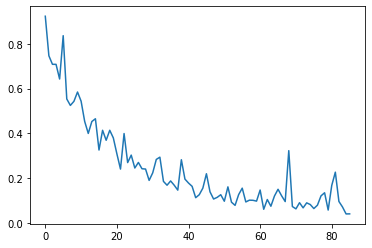

Epoch 1/100
22/22 - 5s - loss: 0.9695 - accuracy: 0.5244 - auc_77: 0.5543 - precision_77: 0.5078 - recall_77: 0.4954 - f1_score: 0.6514 - val_loss: 6.8135 - val_accuracy: 0.5200 - val_auc_77: 0.5000 - val_precision_77: 0.5200 - val_recall_77: 1.0000 - val_f1_score: 0.6842 - 5s/epoch - 217ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7530 - accuracy: 0.6307 - auc_77: 0.6896 - precision_77: 0.6262 - recall_77: 0.5841 - f1_score: 0.6514 - val_loss: 1.4499 - val_accuracy: 0.5200 - val_auc_77: 0.5994 - val_precision_77: 0.5789 - val_recall_77: 0.2821 - val_f1_score: 0.6842 - 1s/epoch - 52ms/step
Epoch 3/100
22/22 - 1s - loss: 0.8184 - accuracy: 0.6130 - auc_77: 0.6777 - precision_77: 0.6052 - recall_77: 0.5719 - f1_score: 0.6514 - val_loss: 3.1385 - val_accuracy: 0.5200 - val_auc_77: 0.5962 - val_precision_77: 0.5200 - val_recall_77: 1.0000 - val_f1_score: 0.6842 - 1s/epoch - 52ms/step
Epoch 4/100
22/22 - 1s - loss: 0.5892 - accuracy: 0.6972 - auc_77: 0.7760 - precision_77: 0.6930 - recall_77: 0

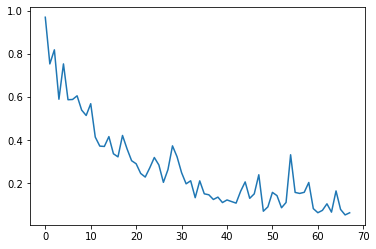

Epoch 1/100
22/22 - 6s - loss: 0.9125 - accuracy: 0.5554 - auc_78: 0.5913 - precision_78: 0.5415 - recall_78: 0.5366 - f1_score: 0.6527 - val_loss: 2.5590 - val_accuracy: 0.4933 - val_auc_78: 0.6860 - val_precision_78: 0.5000 - val_recall_78: 0.9474 - val_f1_score: 0.6726 - 6s/epoch - 258ms/step
Epoch 2/100
22/22 - 1s - loss: 0.9077 - accuracy: 0.6337 - auc_78: 0.6529 - precision_78: 0.6325 - recall_78: 0.5823 - f1_score: 0.6527 - val_loss: 2.9480 - val_accuracy: 0.4800 - val_auc_78: 0.7009 - val_precision_78: 0.4932 - val_recall_78: 0.9474 - val_f1_score: 0.6726 - 1s/epoch - 52ms/step
Epoch 3/100
22/22 - 1s - loss: 0.6903 - accuracy: 0.6780 - auc_78: 0.7322 - precision_78: 0.6786 - recall_78: 0.6372 - f1_score: 0.6527 - val_loss: 4.1127 - val_accuracy: 0.5067 - val_auc_78: 0.5405 - val_precision_78: 0.5067 - val_recall_78: 1.0000 - val_f1_score: 0.6726 - 1s/epoch - 53ms/step
Epoch 4/100
22/22 - 1s - loss: 0.6272 - accuracy: 0.6750 - auc_78: 0.7595 - precision_78: 0.6731 - recall_78: 0

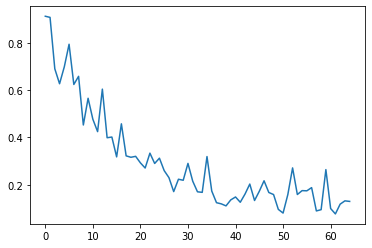

Epoch 1/100
22/22 - 5s - loss: 0.9827 - accuracy: 0.5702 - auc_79: 0.5765 - precision_79: 0.5597 - recall_79: 0.5410 - f1_score: 0.6541 - val_loss: 18.6259 - val_accuracy: 0.4933 - val_auc_79: 0.5000 - val_precision_79: 0.4933 - val_recall_79: 1.0000 - val_f1_score: 0.6607 - 5s/epoch - 238ms/step
Epoch 2/100
22/22 - 1s - loss: 0.7534 - accuracy: 0.6440 - auc_79: 0.7038 - precision_79: 0.6287 - recall_79: 0.6535 - f1_score: 0.6541 - val_loss: 4.3190 - val_accuracy: 0.4933 - val_auc_79: 0.4993 - val_precision_79: 0.4933 - val_recall_79: 1.0000 - val_f1_score: 0.6607 - 1s/epoch - 54ms/step
Epoch 3/100
22/22 - 1s - loss: 0.7148 - accuracy: 0.6632 - auc_79: 0.7201 - precision_79: 0.6689 - recall_79: 0.6079 - f1_score: 0.6541 - val_loss: 5.4922 - val_accuracy: 0.5067 - val_auc_79: 0.5000 - val_precision_79: 0.0000e+00 - val_recall_79: 0.0000e+00 - val_f1_score: 0.6607 - 1s/epoch - 54ms/step
Epoch 4/100
22/22 - 1s - loss: 0.7624 - accuracy: 0.7046 - auc_79: 0.7400 - precision_79: 0.7022 - rec

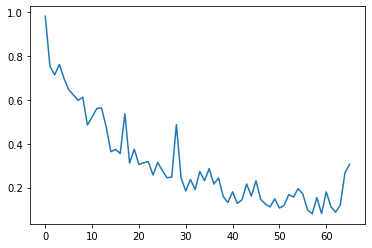

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_latefusion_model = RCNN_fusioned(body_features, face_features, n_length, n_outputs)
    history = rcnn_binary_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_latefusion_model.save(model_path / 'late_binary_rcnn.h5')

#### Training performance

In [ ]:
late_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_rcnn_train_results

{'Accuracy': 0.9608438313007355,
 'ROC/AUC': 0.9882162868976593,
 'Precision': 0.9608291983604431,
 'Recall': 0.9594230771064758,
 'F1-score': 0.6551131784915925}

In [ ]:
late_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
late_rcnn_train_var

{'Accuracy': 0.0007350839579347123,
 'ROC/AUC': 0.00017524049378142337,
 'Precision': 0.0011812642803555207,
 'Recall': 0.0005180753047346798,
 'F1-score': 2.683051290762961e-05}

#### Validation performance

In [ ]:
late_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_rcnn_val_results

{'Accuracy': 0.6437368392944336,
 'ROC/AUC': 0.7134987831115722,
 'Precision': 0.6294152796268463,
 'Recall': 0.7294067084789276,
 'F1-score': 0.6531813502311706}

In [ ]:
late_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
late_rcnn_val_var

{'Accuracy': 0.008421495452477501,
 'ROC/AUC': 0.00590075560086504,
 'Precision': 0.008376645861139096,
 'Recall': 0.012326953609746349,
 'F1-score': 0.002107843036809385}

#### Predictions and performance on test set

In [ ]:
rcnn_binary_latefusion_model = load_model(model_path / 'late_binary_rcnn.h5')
y_pred = rcnn_binary_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = rcnn_binary_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
rcnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 14ms/step - loss: 1.9860 - accuracy: 0.3507 - auc_76: 0.5611 - precision_76: 0.8519 - recall_76: 0.2987 - f1_score: 0.9259
Accuracy: 35.07% 
ROC/AUC: 0.56 
Precision: 0.85 
Recall: 0.30 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

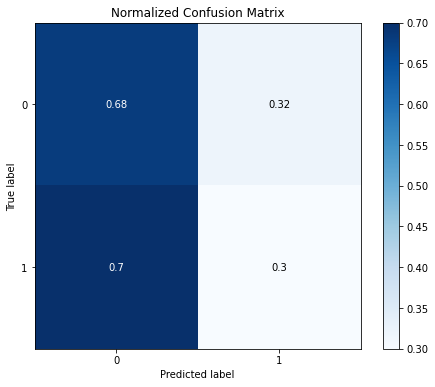

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

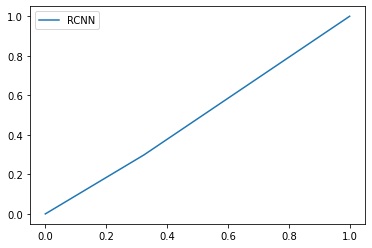

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

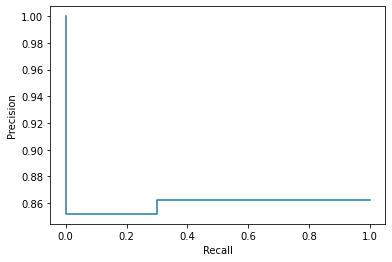

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 4.3 Ensemble

In [ ]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_binary_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_binary_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))

In [ ]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [ ]:
e = dirichletEnsemble.describe()
cnnlstm_auc.append(round(e, 2))
rcnn_auc.append(0)

CNN + Bidirectional LSTM Body Model (weight: 0.0078)
RCNN Body Model (weight: 0.0285)
CNN + Bidirectional LSTM Face Model (weight: 0.2455)
RCNN Face Model (weight: 0.7182)
Accuracy: 100.00% - ROC/AUC: 0.66 - Precision: 1.00 - Recall: 1.00 - F1 score: 1.00


## Results

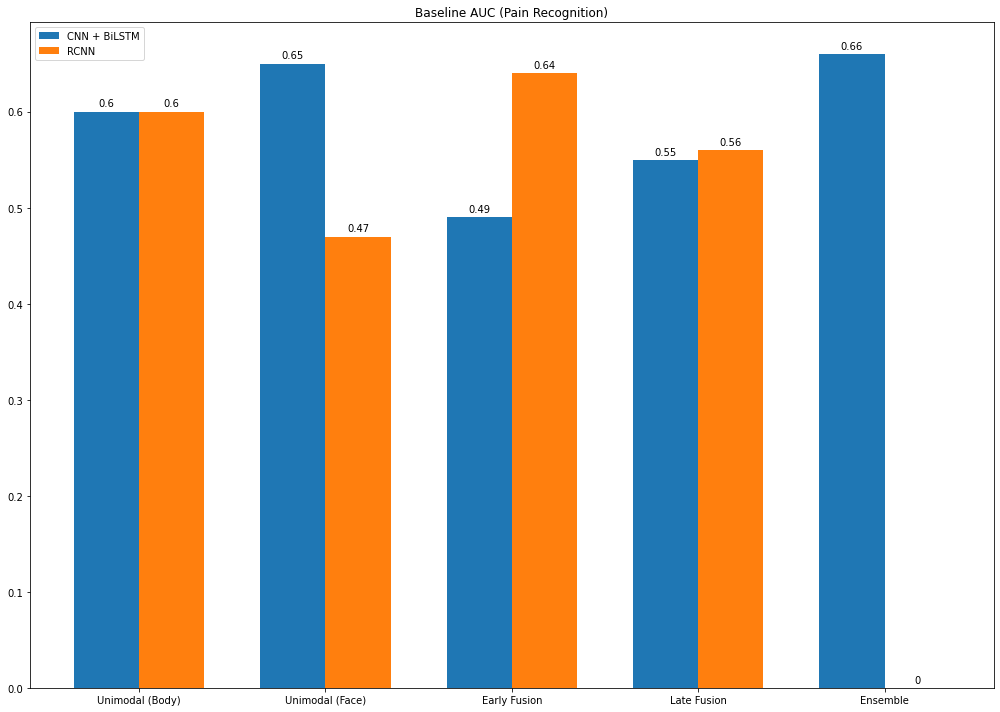

In [ ]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, cnnlstm_auc, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, rcnn_auc, width, label='RCNN')

ax.set_title('Baseline AUC (Pain Recognition)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()